In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from IPython.display import display, HTML
from scipy.spatial.distance import squareform


root_path = os.path.abspath(os.path.join(os.path.abspath(""), "../.."))

## Build the PPI similarity network 

In [2]:
### Load table from Chloe that keep PPIs in Tarassov with a distance of zero
zero = pd.read_csv(f'{root_path}/data/networks/tarassov_ppi_distances/zero.csv')
ppi = pd.read_csv(f'{root_path}/data/pipeline/PPI_reference_barcodes.csv')

In [3]:
zero

PPI_1       PPI_2 Prot_1A Prot_1B Prot_2A Prot_2B  distance
0      ERG27:ACF2   TGL4:ACF2   ERG27    ACF2    TGL4    ACF2       0.0
1      ERG27:ACF2   SNA3:ACF2   ERG27    ACF2    SNA3    ACF2       0.0
2      ERG27:ACF2  ERG7:ERG27   ERG27    ACF2    ERG7   ERG27       0.0
3      ERG27:ACF2   ACF2:SEL1   ERG27    ACF2    ACF2    SEL1       0.0
4      ERG27:ACF2  YEH1:ERG27   ERG27    ACF2    YEH1   ERG27       0.0
...           ...         ...     ...     ...     ...     ...       ...
37645  ARF1:ERV29   ARF1:SNA3    ARF1   ERV29    ARF1    SNA3       0.0
37646  ARF1:ERV29   ARF1:ALO1    ARF1   ERV29    ARF1    ALO1       0.0
37647   ARF1:SNA3   ARF1:ALO1    ARF1    SNA3    ARF1    ALO1       0.0
37648   ADH4:SWI6  COX23:SWI6    ADH4    SWI6   COX23    SWI6       0.0
37649   SNQ2:QDR2   MUP1:QDR2    SNQ2    QDR2    MUP1    QDR2       0.0

[37650 rows x 7 columns]

In [4]:
#### Some PPI bait and prey might be reversed in the Chloe's network, so we take account of both versions
PPI_1 =[ ppi['ppi'][idx] for idx in ppi['ppi'].index ]
PPI_2 = [ f'{ppi["ppi"][idx].split(":")[1]}:{ppi["ppi"][idx].split(":")[0]}' for idx in ppi['ppi'].index ]
all_PPIs = [*PPI_1, *PPI_2]

In [5]:
#### Collect the edges that involves one of our 61 PPIs of interest
piQTL_PPIs = zero[(zero['PPI_1'].isin(all_PPIs))|(zero['PPI_2'].isin(all_PPIs)) ][['PPI_1', 'PPI_2']].values

In [6]:
pd.DataFrame(piQTL_PPIs, columns=['PPI_1', 'PPI_2']) # .to_csv('../results/09_PPI_network/PPI_similarity_network.csv', index=False)

PPI_1       PPI_2
0     ERG27:ACF2   TGL4:ACF2
1     ERG27:ACF2   SNA3:ACF2
2     ERG27:ACF2  ERG7:ERG27
3     ERG27:ACF2   ACF2:SEL1
4     ERG27:ACF2  YEH1:ERG27
...          ...         ...
3120   MID2:MYO5   TPO1:MID2
3121   FTR1:MID2   TPO1:MID2
3122   TPO1:MID2   TPO1:RSA3
3123   PLM2:SNA3   ARF1:SNA3
3124   PLM2:SNA3   PLM2:YOR1

[3125 rows x 2 columns]

In [7]:
#### Build the PPI similarity network
G = nx.Graph()
G.add_edges_from(piQTL_PPIs)

In [8]:
#### Stats of nodes and edges 
len(G.nodes()), len(G.edges())

(742, 3125)

61


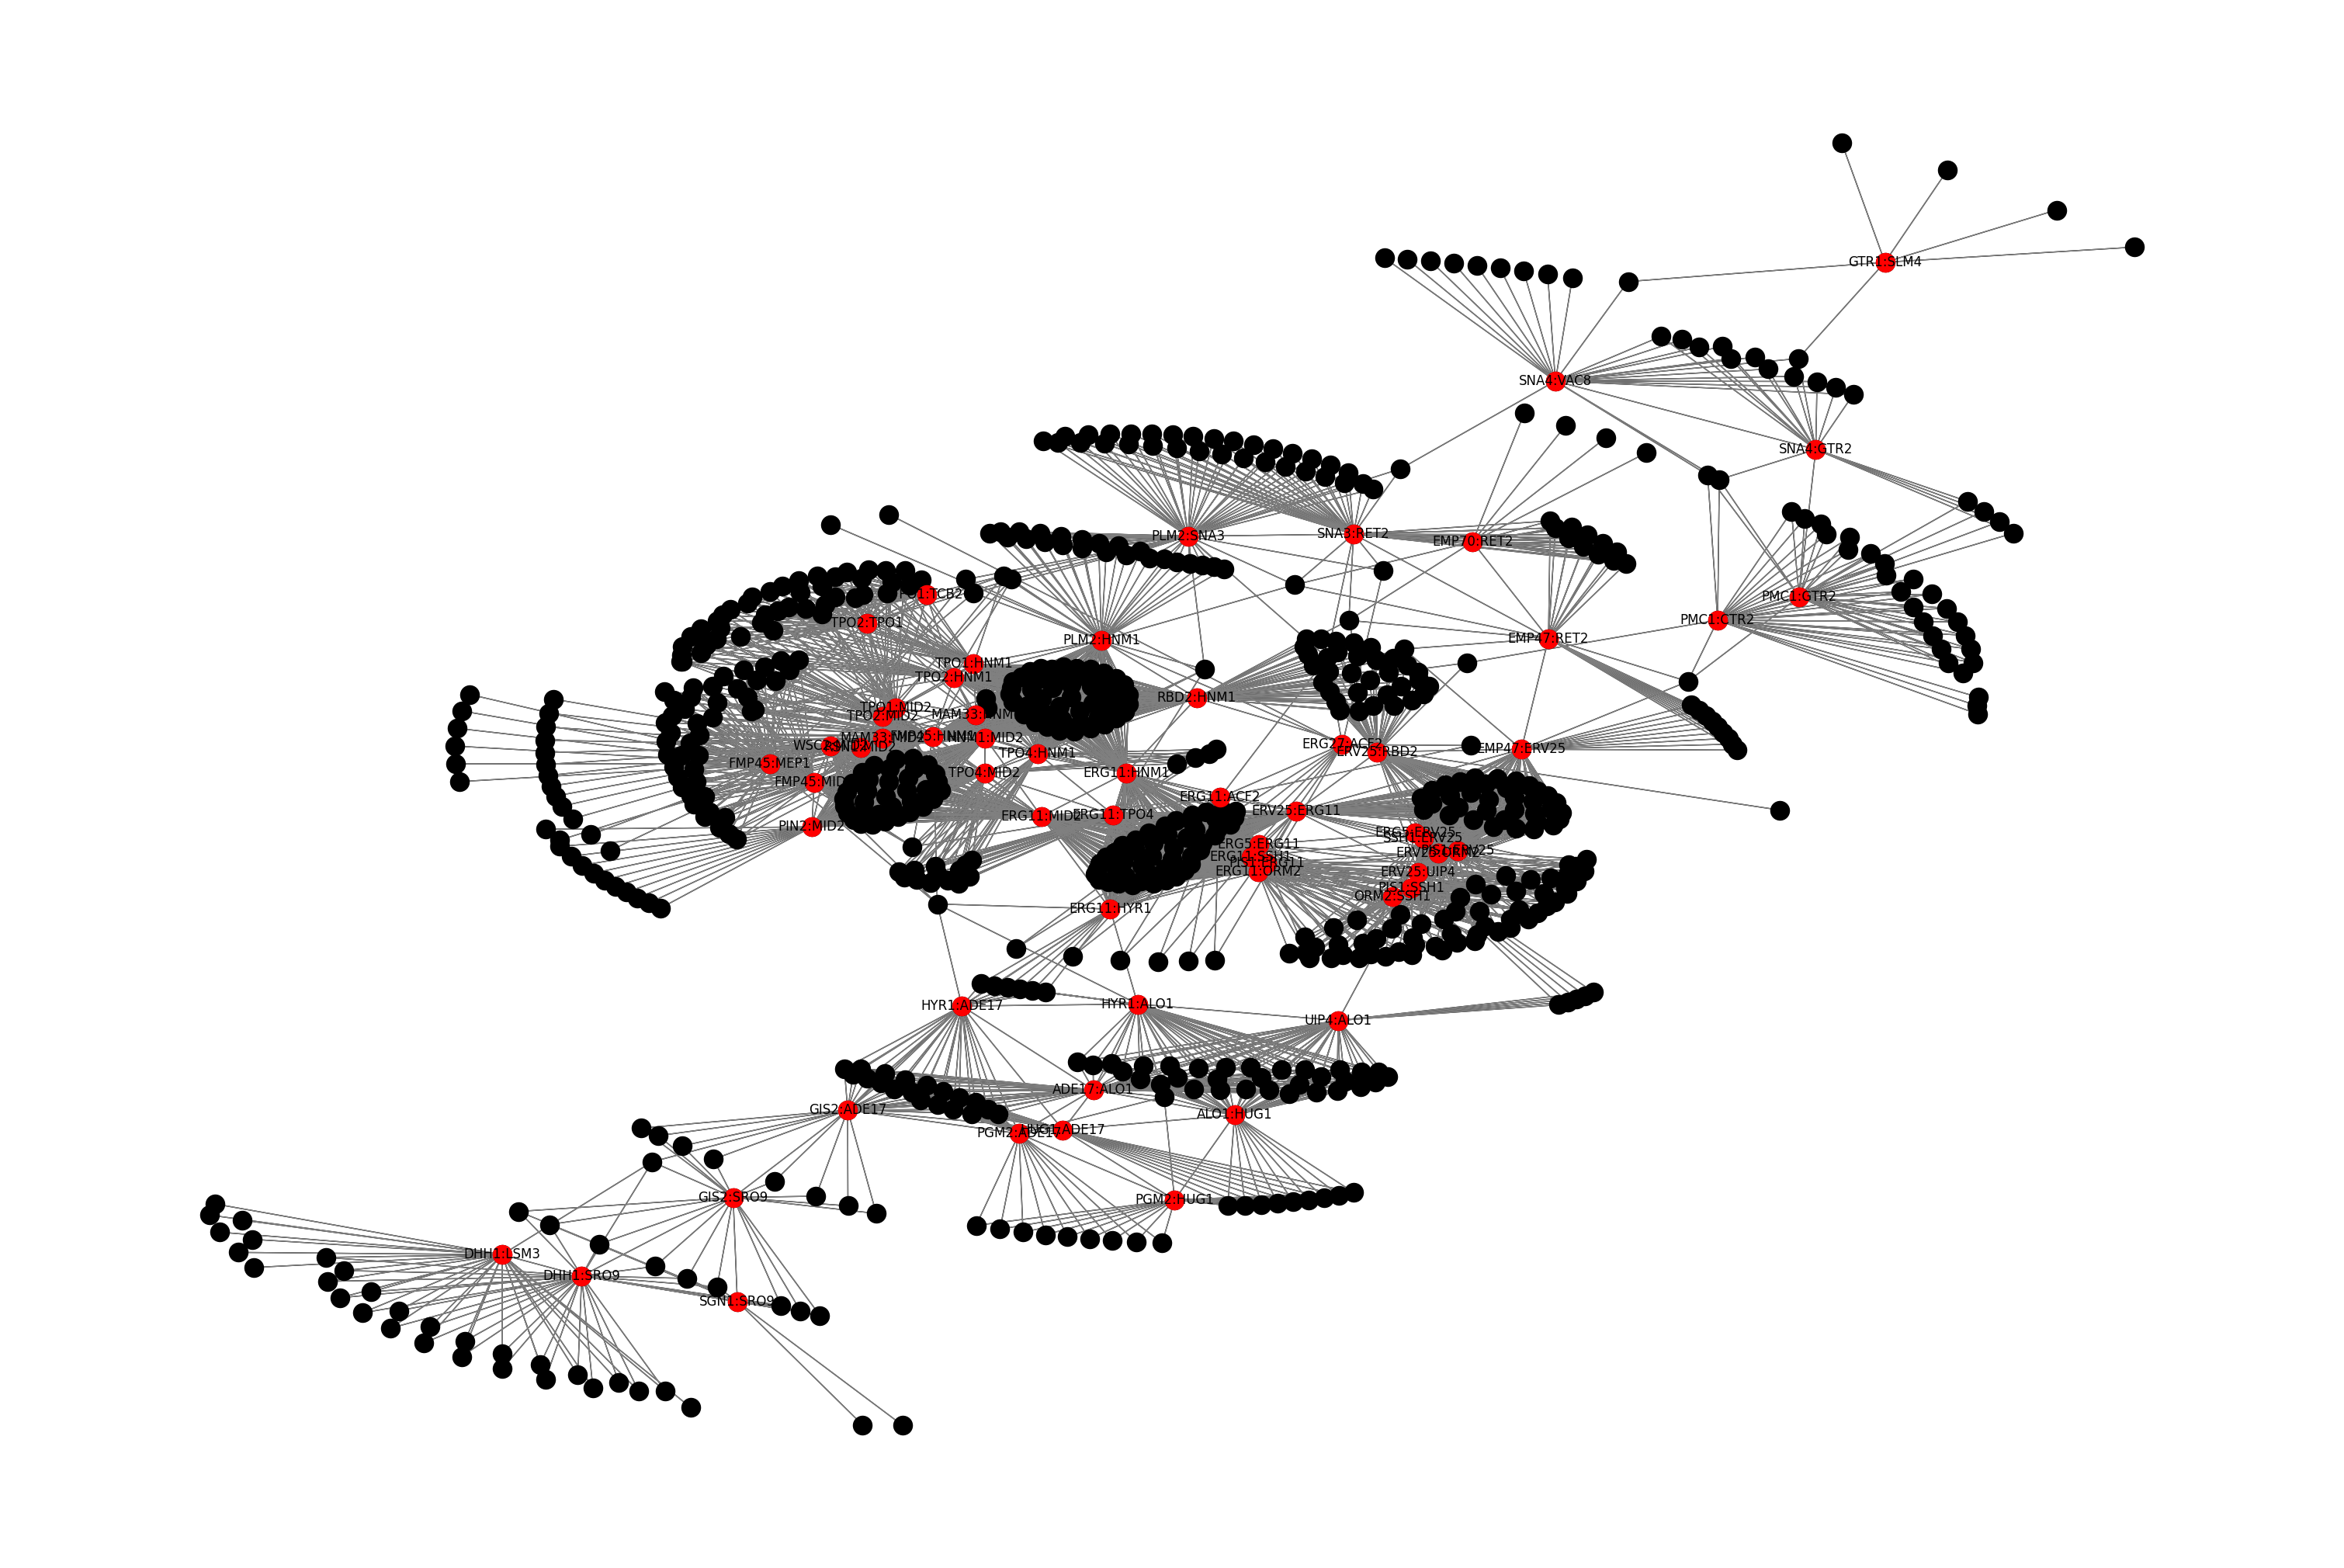

In [9]:
#### Draw the network 
node_list = [ ppi for ppi in all_PPIs if ppi in G.nodes ]
print(len(node_list))

f = plt.figure(figsize=(30,20))
nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G, prog="neato"), node_color='black')
nx.draw_networkx_edges(G, pos=nx.nx_agraph.graphviz_layout(G, prog="neato"), edge_color='grey')
nx.draw_networkx_nodes(G, pos=nx.nx_agraph.graphviz_layout(G, prog="neato"), nodelist=node_list, node_color='red')
nx.draw_networkx_labels(G, pos=nx.nx_agraph.graphviz_layout(G, prog="neato"), labels={n: n for n in G if n in node_list})
plt.show()

In [10]:
#### Calculate the distance between each node 
dist_matrix = nx.floyd_warshall_numpy(G)
df = pd.DataFrame(dist_matrix, columns=G.nodes(), index=G.nodes())
df = df.reset_index().rename(columns={"index":"PPI"}).set_index('PPI')

In [11]:
df

ERG27:ACF2  TGL4:ACF2  SNA3:ACF2  ERG7:ERG27  ACF2:SEL1  \
PPI                                                                   
ERG27:ACF2         0.0        1.0        1.0         1.0        1.0   
TGL4:ACF2          1.0        0.0        2.0         2.0        2.0   
SNA3:ACF2          1.0        2.0        0.0         2.0        2.0   
ERG7:ERG27         1.0        2.0        2.0         0.0        2.0   
ACF2:SEL1          1.0        2.0        2.0         2.0        0.0   
...                ...        ...        ...         ...        ...   
DPP1:VAC8          5.0        6.0        4.0         6.0        6.0   
FLC2:PLM2          3.0        4.0        2.0         4.0        4.0   
PLM2:FLC1          3.0        4.0        2.0         4.0        4.0   
PLM2:QDR2          3.0        4.0        2.0         4.0        4.0   
PLM2:YOR1          3.0        4.0        2.0         4.0        4.0   

            YEH1:ERG27  FAT1:ERG27  EHT1:ACF2  ERG7:ACF2  ERG11:ACF2  ...  \
PPI                                                                   ...   
ERG27:ACF2         1.0         1.0        1.0        1.0         1.0  ...   
TGL4:ACF2          2.0         2.0        2.0        2.0         1.0  ...   
SNA3:ACF2          2.0         2.0        2.0        2.0         1.0  ...   
ERG7:ERG27         2.0         2.0        2.0        2.0         2.0  ...   
ACF2:SEL1          2.0         2.0        2.0        2.0         1.0  ...   
...                ...         ...        ...        ...         ...  ...   
DPP1:VAC8          6.0         6.0        6.0        6.0         5.0  ...   
FLC2:PLM2          4.0         4.0        4.0        4.0         3.0  ...   
PLM2:FLC1          4.0         4.0        4.0        4.0         3.0  ...   
PLM2:QDR2          4.0         4.0        4.0        4.0         3.0  ...   
PLM2:YOR1          4.0         4.0        4.0        4.0         3.0  ...   

            PLM2:SEC27  SWH1:VAC8  VAC8:HXT1  VAC8:MEH1  VAC8:IML1  DPP1:VAC8  \
PPI                                                                             
ERG27:ACF2         3.0        5.0        5.0        5.0        5.0        5.0   
TGL4:ACF2          4.0        6.0        6.0        6.0        6.0        6.0   
SNA3:ACF2          2.0        4.0        4.0        4.0        4.0        4.0   
ERG7:ERG27         4.0        6.0        6.0        6.0        6.0        6.0   
ACF2:SEL1          4.0        6.0        6.0        6.0        6.0        6.0   
...                ...        ...        ...        ...        ...        ...   
DPP1:VAC8          4.0        2.0        2.0        2.0        2.0        0.0   
FLC2:PLM2          2.0        4.0        4.0        4.0        4.0        4.0   
PLM2:FLC1          2.0        4.0        4.0        4.0        4.0        4.0   
PLM2:QDR2          2.0        4.0        4.0        4.0        4.0        4.0   
PLM2:YOR1          2.0        4.0        4.0        4.0        4.0        4.0   

            FLC2:PLM2  PLM2:FLC1  PLM2:QDR2  PLM2:YOR1  
PPI                                                     
ERG27:ACF2        3.0        3.0        3.0        3.0  
TGL4:ACF2         4.0        4.0        4.0        4.0  
SNA3:ACF2         2.0        2.0        2.0        2.0  
ERG7:ERG27        4.0        4.0        4.0        4.0  
ACF2:SEL1         4.0        4.0        4.0        4.0  
...               ...        ...        ...        ...  
DPP1:VAC8         4.0        4.0        4.0        4.0  
FLC2:PLM2         0.0        2.0        2.0        2.0  
PLM2:FLC1         2.0        0.0        2.0        2.0  
PLM2:QDR2         2.0        2.0        0.0        2.0  
PLM2:YOR1         2.0        2.0        2.0        0.0  

[742 rows x 742 columns]

In [12]:
#### Save the distance matrix
df.to_csv(f'{root_path}/results/07_network_analysis/distance_matrix_piQTLs.csv')

In [13]:
#### Subset the distance matrix with only the 61 PPIs 
filter =  [ ppi for ppi in all_PPIs if (ppi in G.nodes()) ] # and (ppi not in ['DHH1:LSM3','DHH1:SRO9'])
piQTLs = df.loc[[ ppi for ppi in all_PPIs if ppi in filter ], [ ppi for ppi in all_PPIs if ppi in filter ]]

In [14]:
stacked = piQTLs.stack()
piQTLs_distance_flat = stacked.reset_index().rename(columns={'PPI':'PPI1', 'level_1':'PPI2', 0:'distance'})
piQTLs_distance_flat

PPI1        PPI2  distance
0      GTR1:SLM4   GTR1:SLM4       0.0
1      GTR1:SLM4   SNA4:GTR2       2.0
2      GTR1:SLM4  ERG11:HYR1       7.0
3      GTR1:SLM4   DHH1:LSM3      11.0
4      GTR1:SLM4  ERV25:ORM2       6.0
...          ...         ...       ...
3716  ADE17:ALO1  PGM2:ADE17       1.0
3717  ADE17:ALO1  MAM33:MID2       4.0
3718  ADE17:ALO1   WSC2:MID2       4.0
3719  ADE17:ALO1   TPO2:HNM1       4.0
3720  ADE17:ALO1  ADE17:ALO1       0.0

[3721 rows x 3 columns]

/home/docker/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


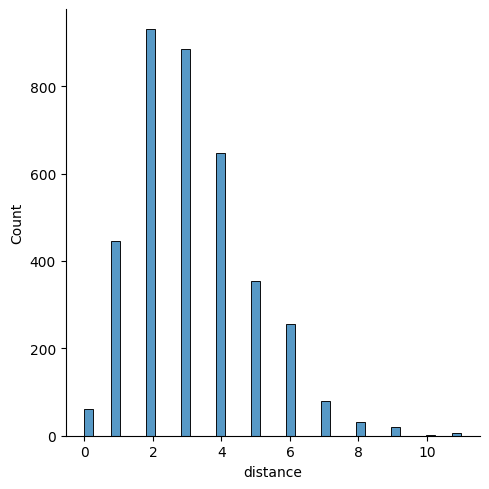

In [15]:
sns.displot(piQTLs_distance_flat['distance'])

In [16]:
len(G.nodes())

742

In [17]:
R = nx.erdos_renyi_graph(742, p=0.5)

## Hierarchical clustering of the PPI similarity network

/home/docker/.local/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/docker/.local/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


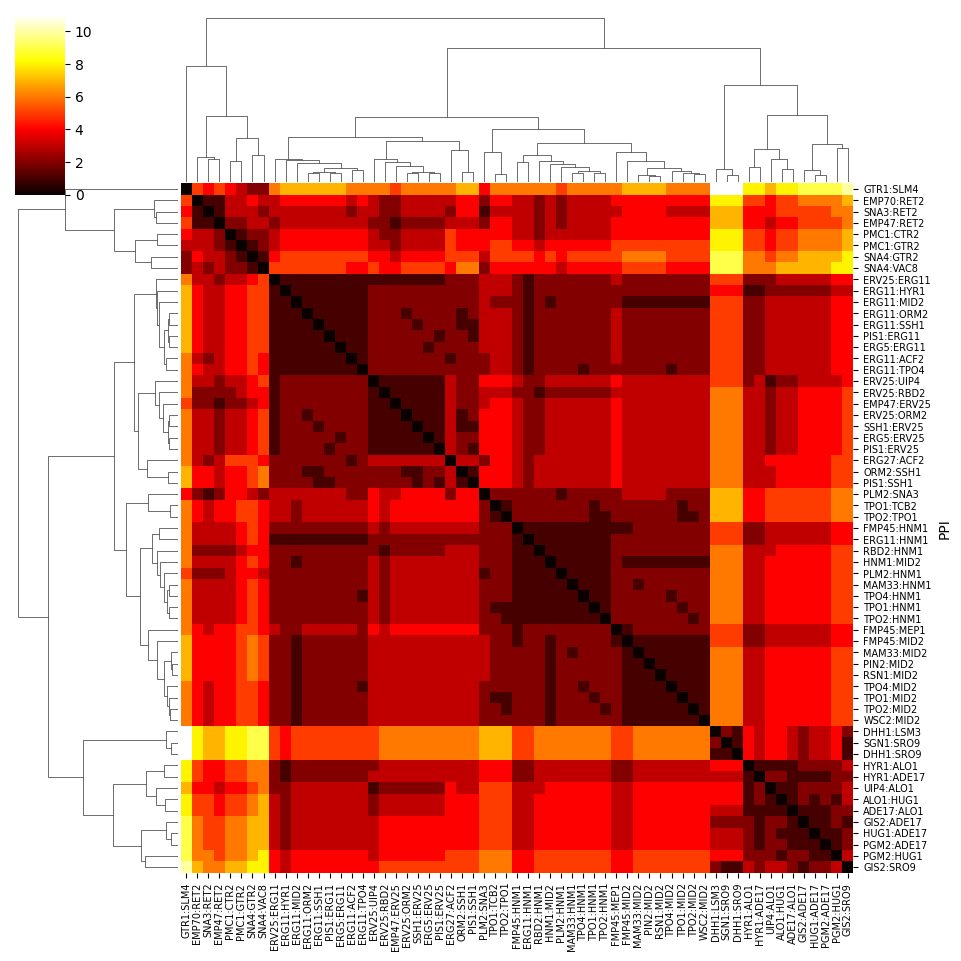

In [18]:
g = sns.clustermap(piQTLs, cmap='hot', method='complete', xticklabels=True, yticklabels=True)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 7)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)
g.savefig(f"{root_path}/figures/supp_figures/distance_clustermap_PPI_distance_network.eps", dpi=300)

#### g.dendrogram_row.reordered_ind provide the index from the distance matrix that will help you to order the manhatthan similarity matrix

In [19]:
f = open('PPI_similarity_network_order.txt', 'w')
for PPI in piQTLs.index[g.dendrogram_row.reordered_ind]:
    f.write(f'{PPI}\n')
f.close()

____

## piQTL manhattan plots

In [20]:
PPI_list = pd.read_csv(f'{root_path}/data/pipeline/PPI_reference_barcodes.csv')
PPI_list['PPI_bait'] =  [ PPI_list['PPI'][idx].split('_')[0] for idx in PPI_list.index ]
PPI_list['PPI_prey'] =  [ PPI_list['PPI'][idx].split('_')[1] for idx in PPI_list.index ]

In [21]:
def get_chr(x, gene_loc):
    try : 
        return gene_loc[gene_loc['Gene'] == x]['Chromosome_Name'].values[0].replace('CHR', '')
    except : 
        return np.nan
        
def set_correlation_score(idx, table):
    z_score = table['-log_pval'][idx]
    effect = table['EFFECTSIZE'][idx]
    if z_score >= 4 : #### Here you can play with this threshold
        return 1
    else :
        return 0

In [22]:
#### Here I'm building the manhatthan similarity matrix across all the conditions
folder_path = f'{root_path}/data/QTL/'
all_MTX = []
MTX_correlation_matrix = []
for PPI in tqdm(PPI_list['PPI']):
    for DRUG in ['noDrug', '5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine'] :
        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX['SNP_ID'] = [ f'CHR{MTX["CHR"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        MTX['-log_pval'] = -np.log10(MTX['P'])
        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        all_MTX.append(MTX)
        MTX_correlation_matrix.append(MTX[['SNP_ID', f'{PPI}_MTX_{DRUG}']].set_index(['SNP_ID']).T)
MTX_DF = pd.concat(MTX_correlation_matrix)

  0%|          | 0/62 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/work/data/QTL/GTR1_SLM4_MTX_noDrug_avg_logratio_Fitness_minus_ref.csv'

In [ ]:
MTX_DF[MTX_DF['CHR8_4979'] == 1] ['CHR8_4979']

DHH1_LSM3_MTX_Fluconazole     1
MID2_PIN2_MTX_Fluconazole     1
ERG11_PIS1_MTX_Fluconazole    1
SSH1_ERV25_MTX_Metformin      1
PMC1_CTR2_MTX_Fluconazole     1
TPO1_MID2_MTX_Fluconazole     1
Name: CHR8_4979, dtype: int64

In [ ]:
#### You need to remove the MTX-specific piQTLs before performing the other steps
MTX_QTLs = pd.read_csv(f'{root_path}/results/05_piQTL_tables/MTX_specific_QTLs_with_genome_annotations.csv')
MTX_QTLs['SNP_ID'] = [ f'CHR{MTX_QTLs["Chr"][idx]}_{MTX_QTLs["SNP"][idx]}' for idx in MTX_QTLs.index ]
len(list(MTX_QTLs['SNP_ID']))

42

In [ ]:
piQTL_QTLs = MTX_DF[[ col for col in MTX_DF.columns if col not in list(MTX_QTLs['SNP_ID'])]].reset_index().rename(columns={'index':'Condition'})

In [ ]:
A = piQTLs.loc[piQTLs.index[g.dendrogram_row.reordered_ind], piQTLs.index[g.dendrogram_row.reordered_ind]].stack()
B = DRUG_hamming.stack()

RES = pd.DataFrame([ (A.values[i], B.values[i]) for i in range(len(A)) ], columns=['PPI_distance', 'piQTL_similarity'])

sns.scatterplot(x=RES['PPI_distance'], y=RES['piQTL_similarity'])
stats.spearmanr(RES['PPI_distance'], RES['piQTL_similarity'])

(61, 542)

(61, 485)

(61, 801)

(61, 705)

(61, 513)

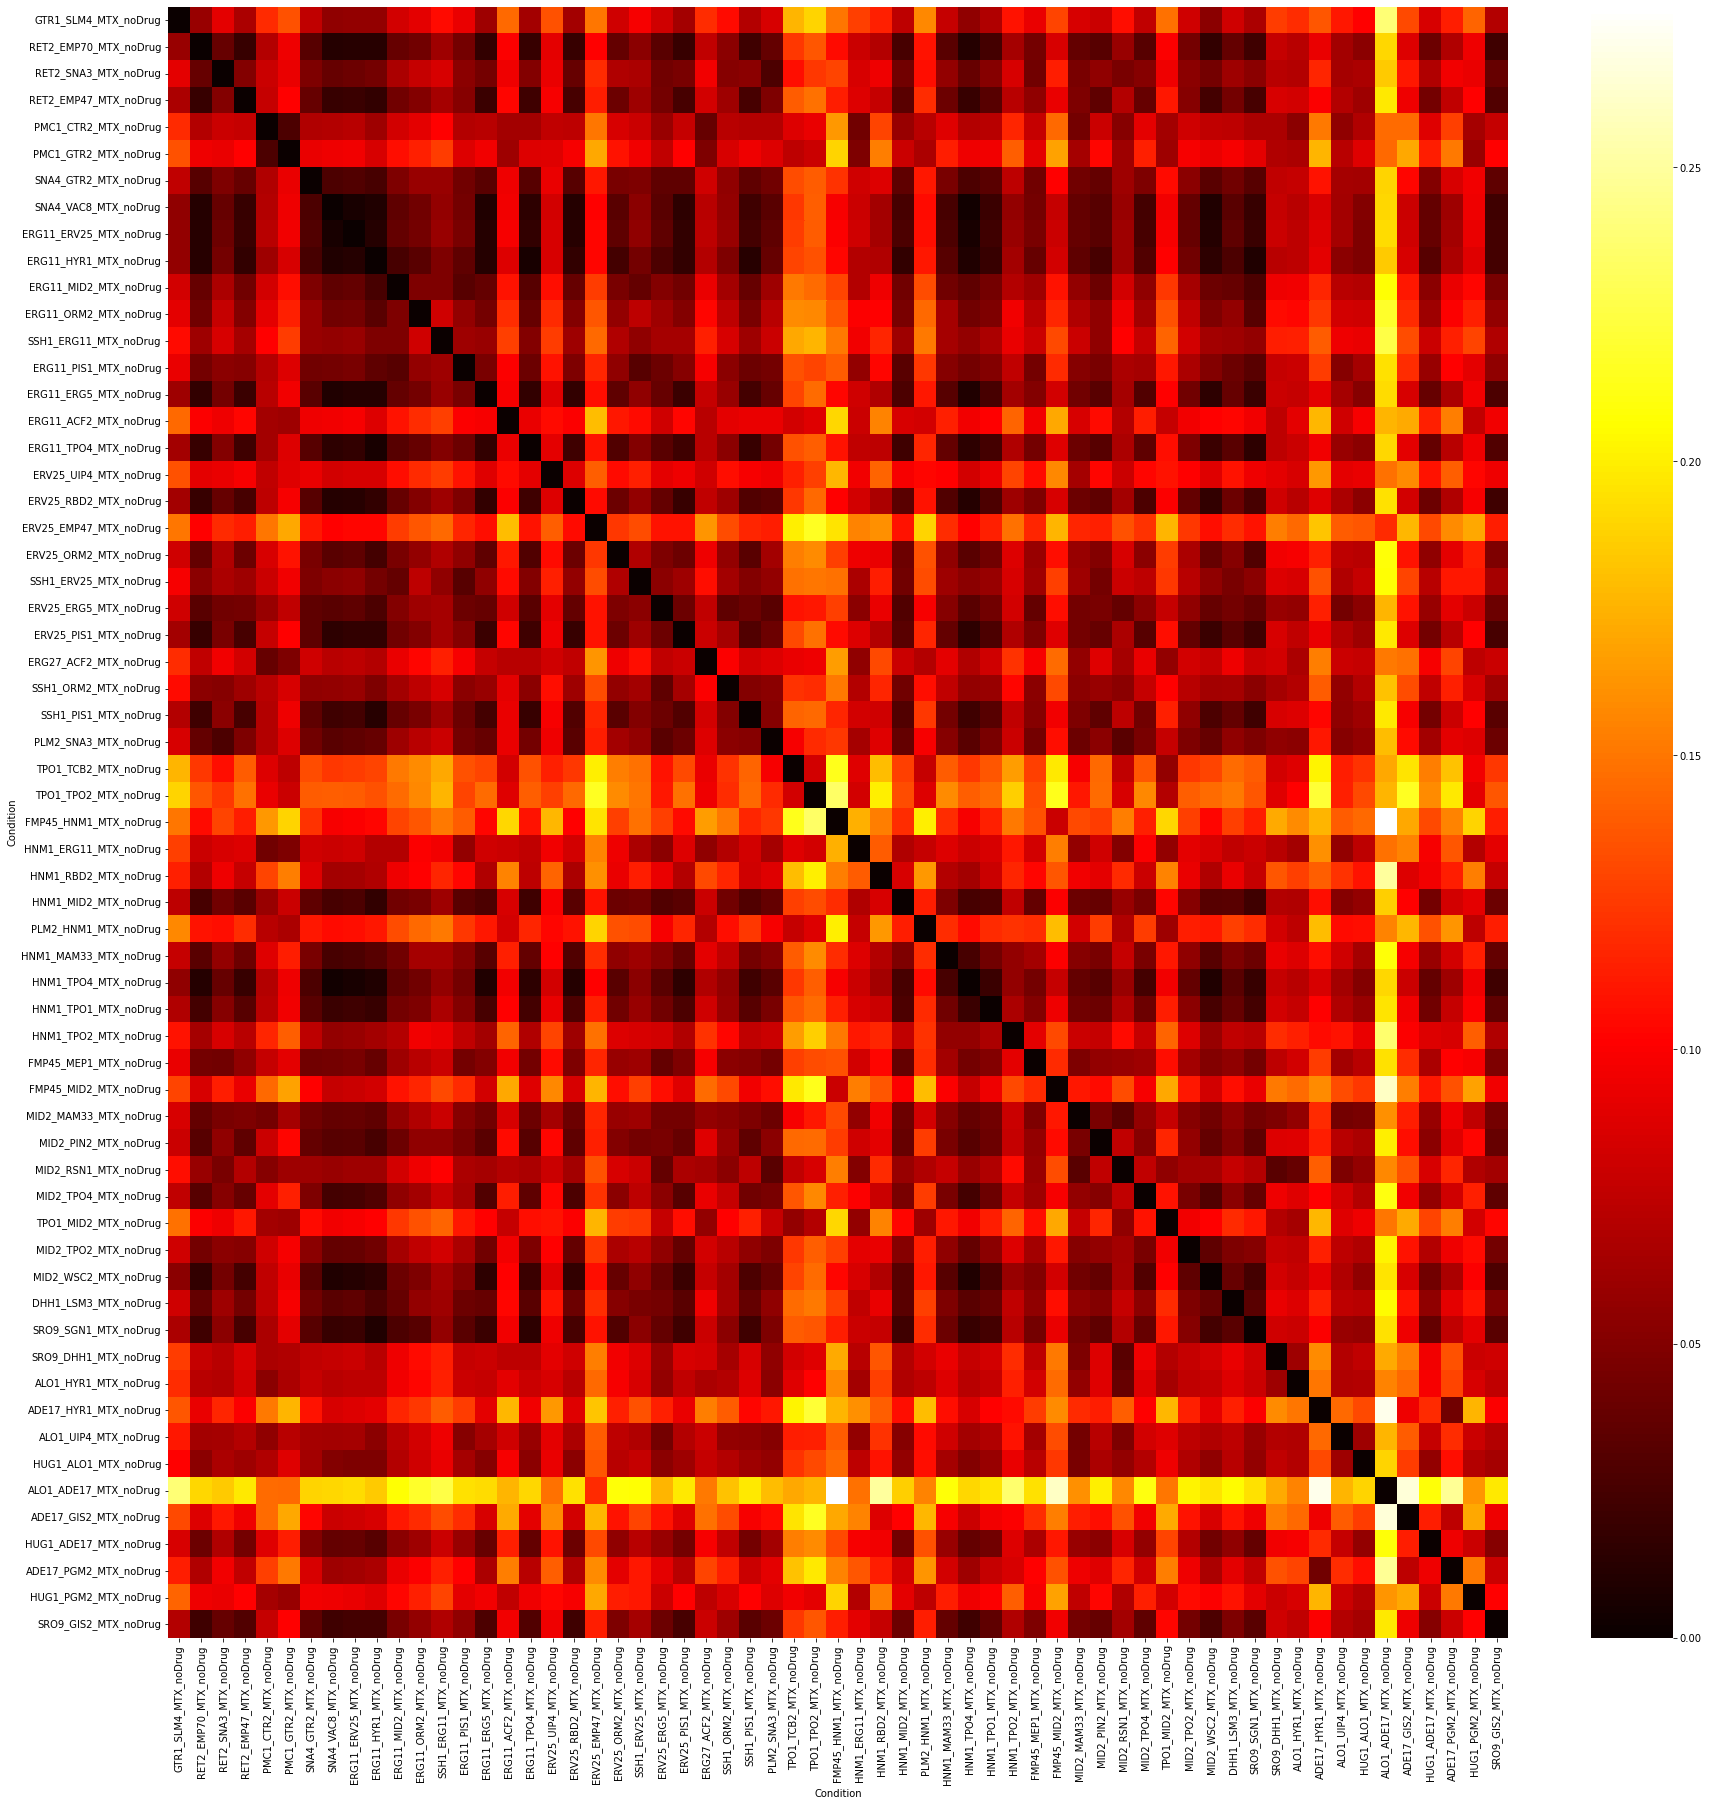

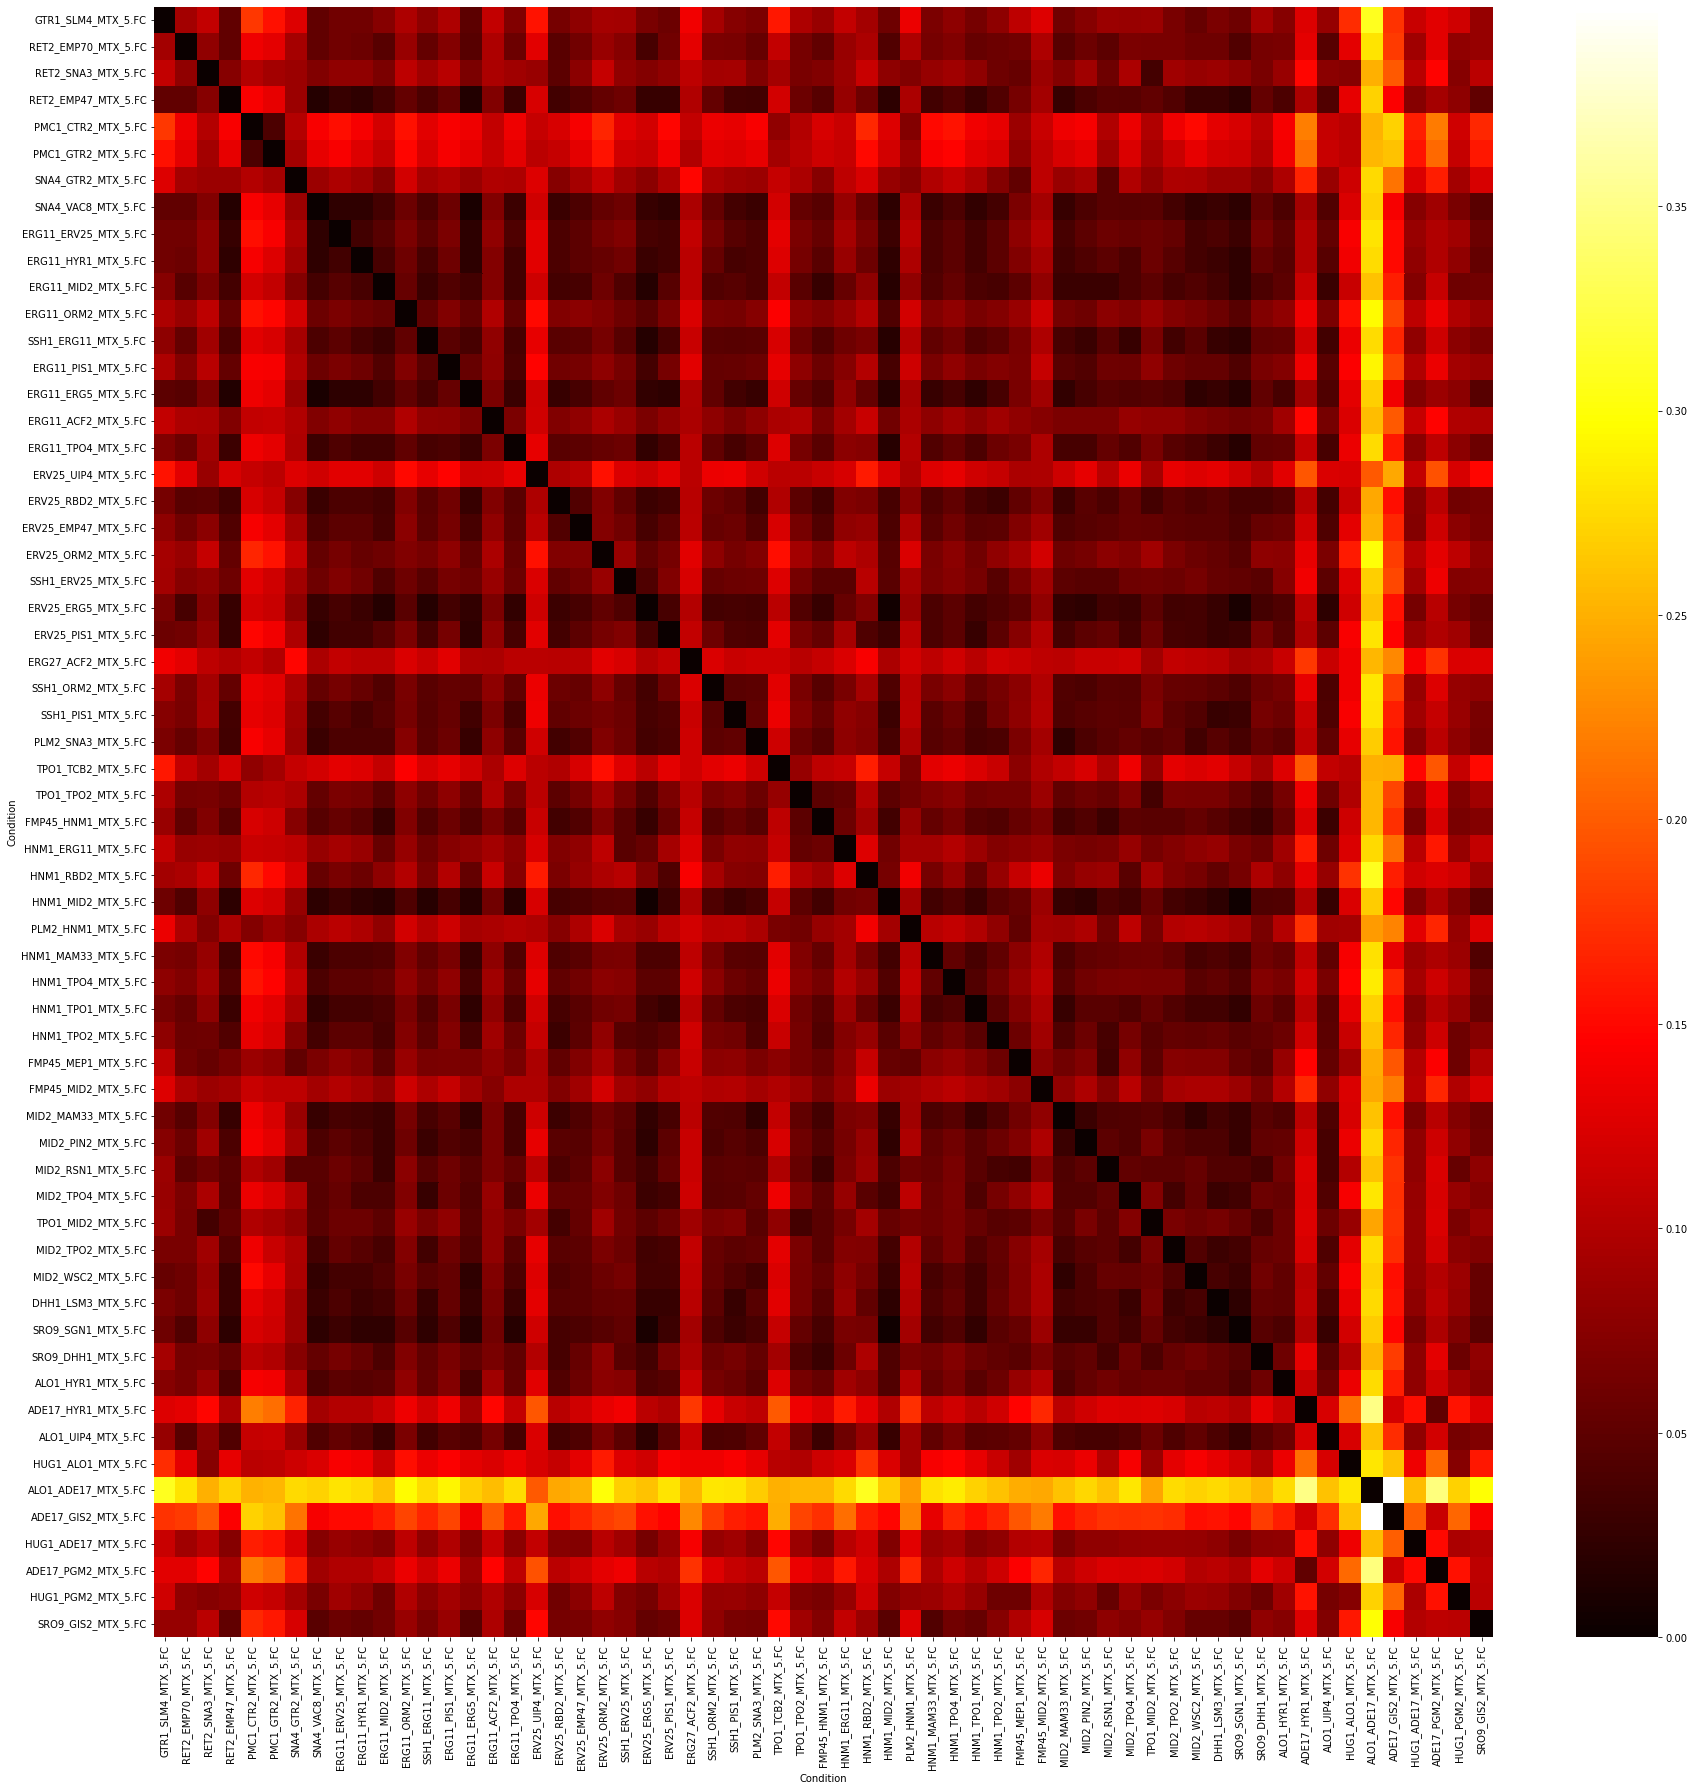

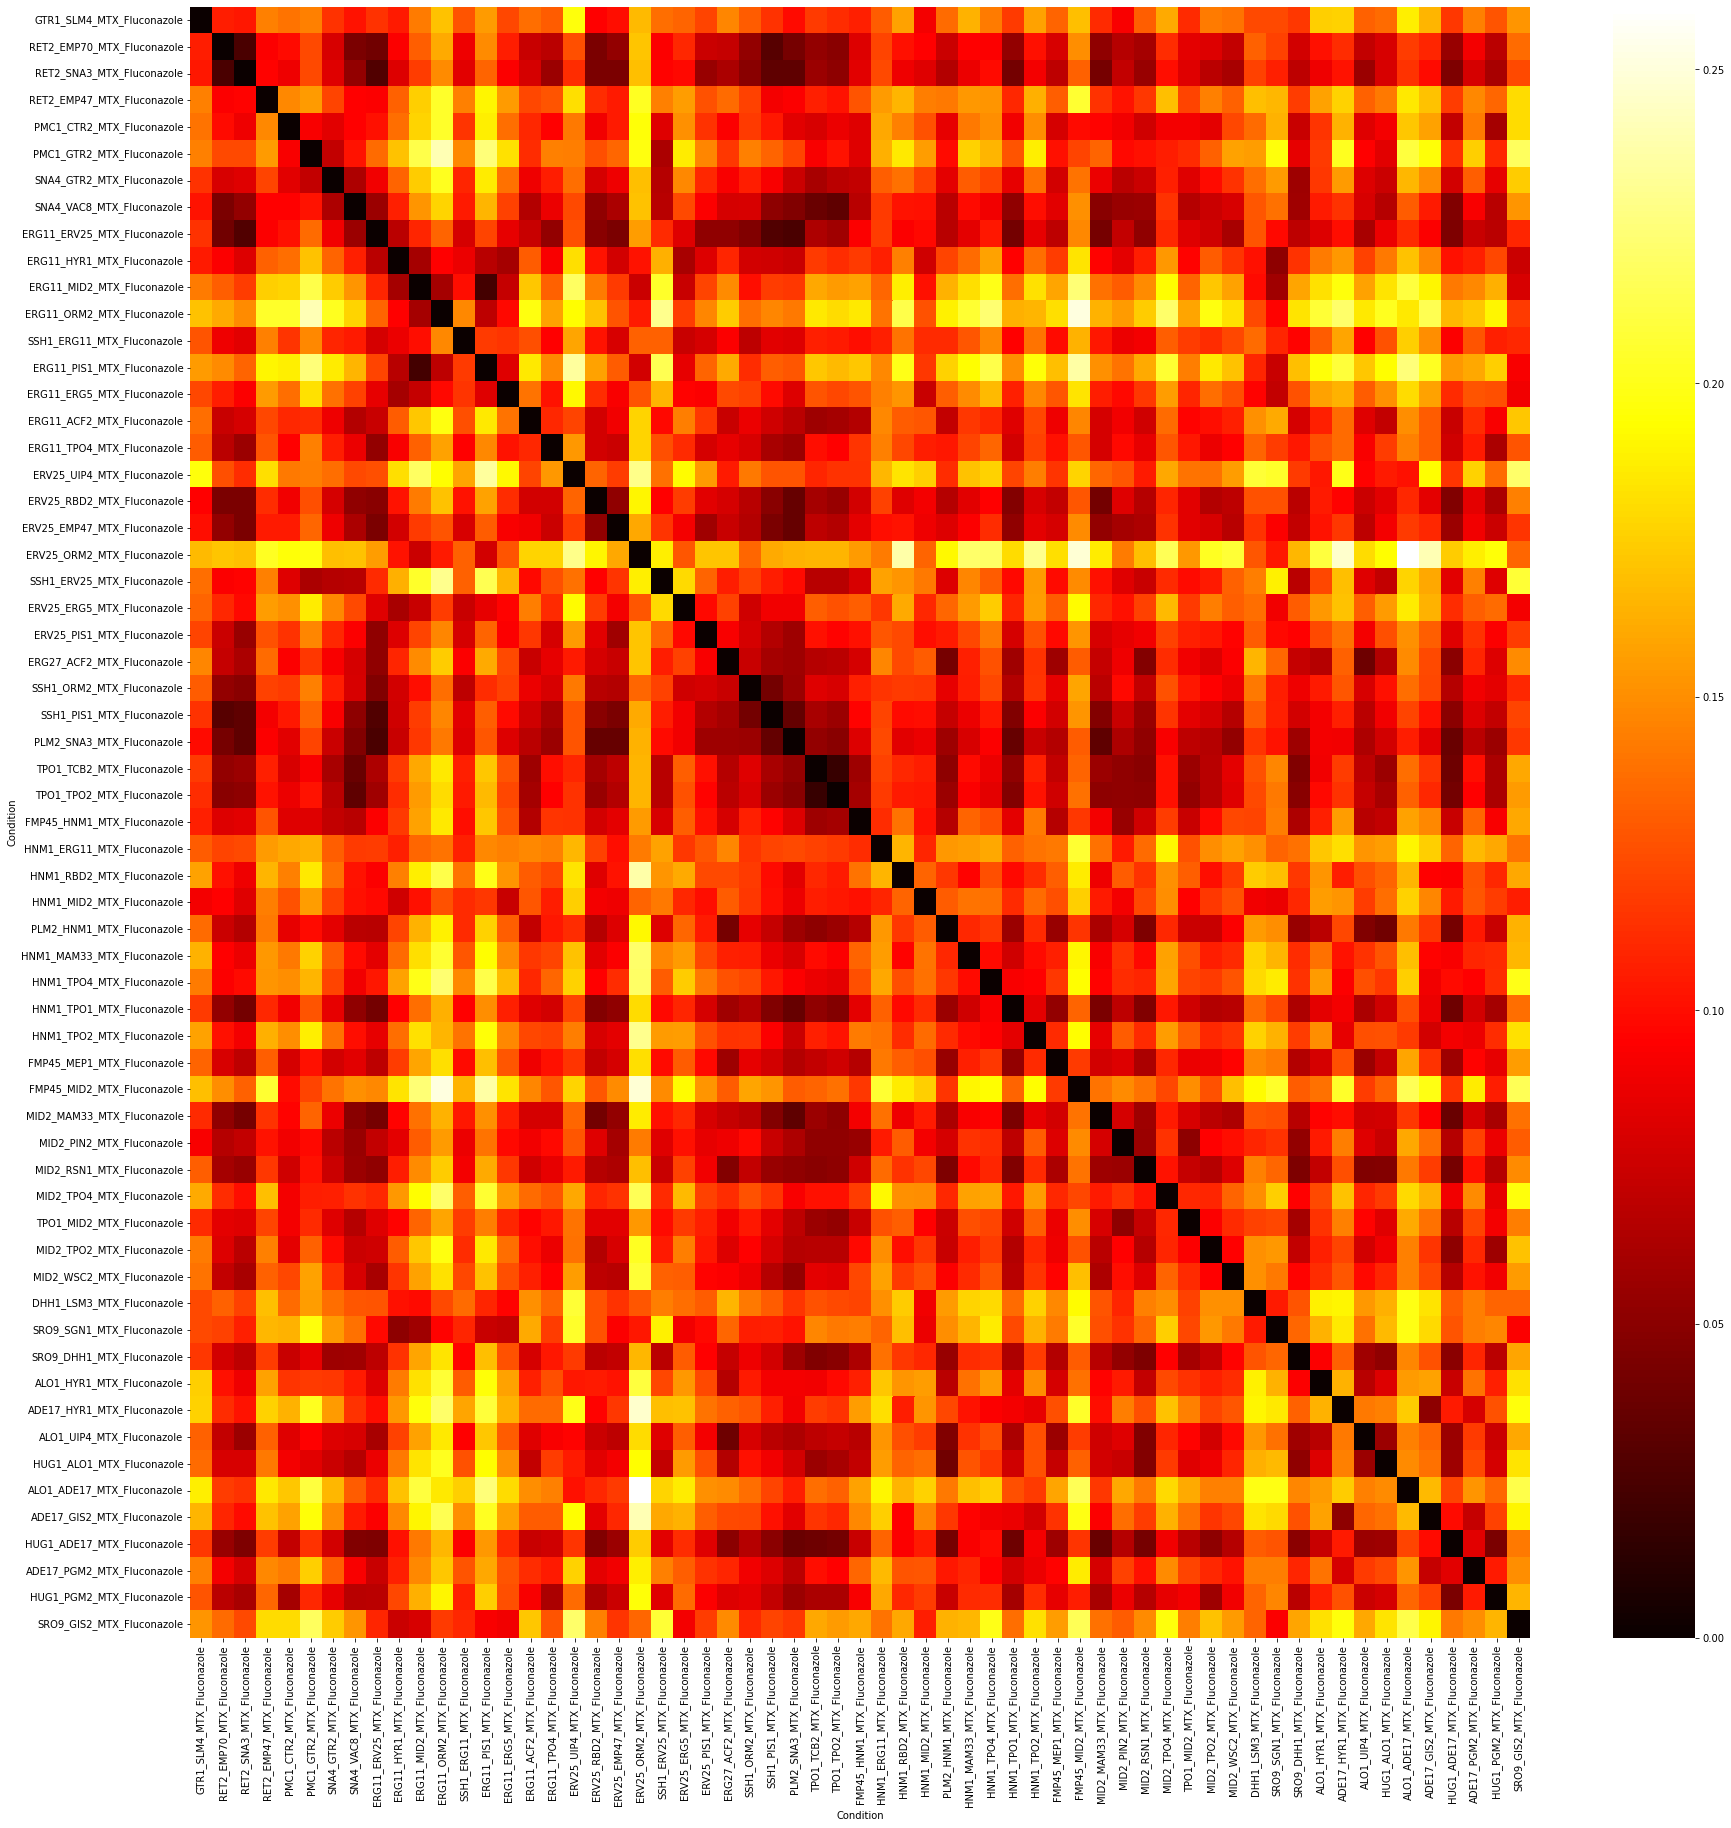

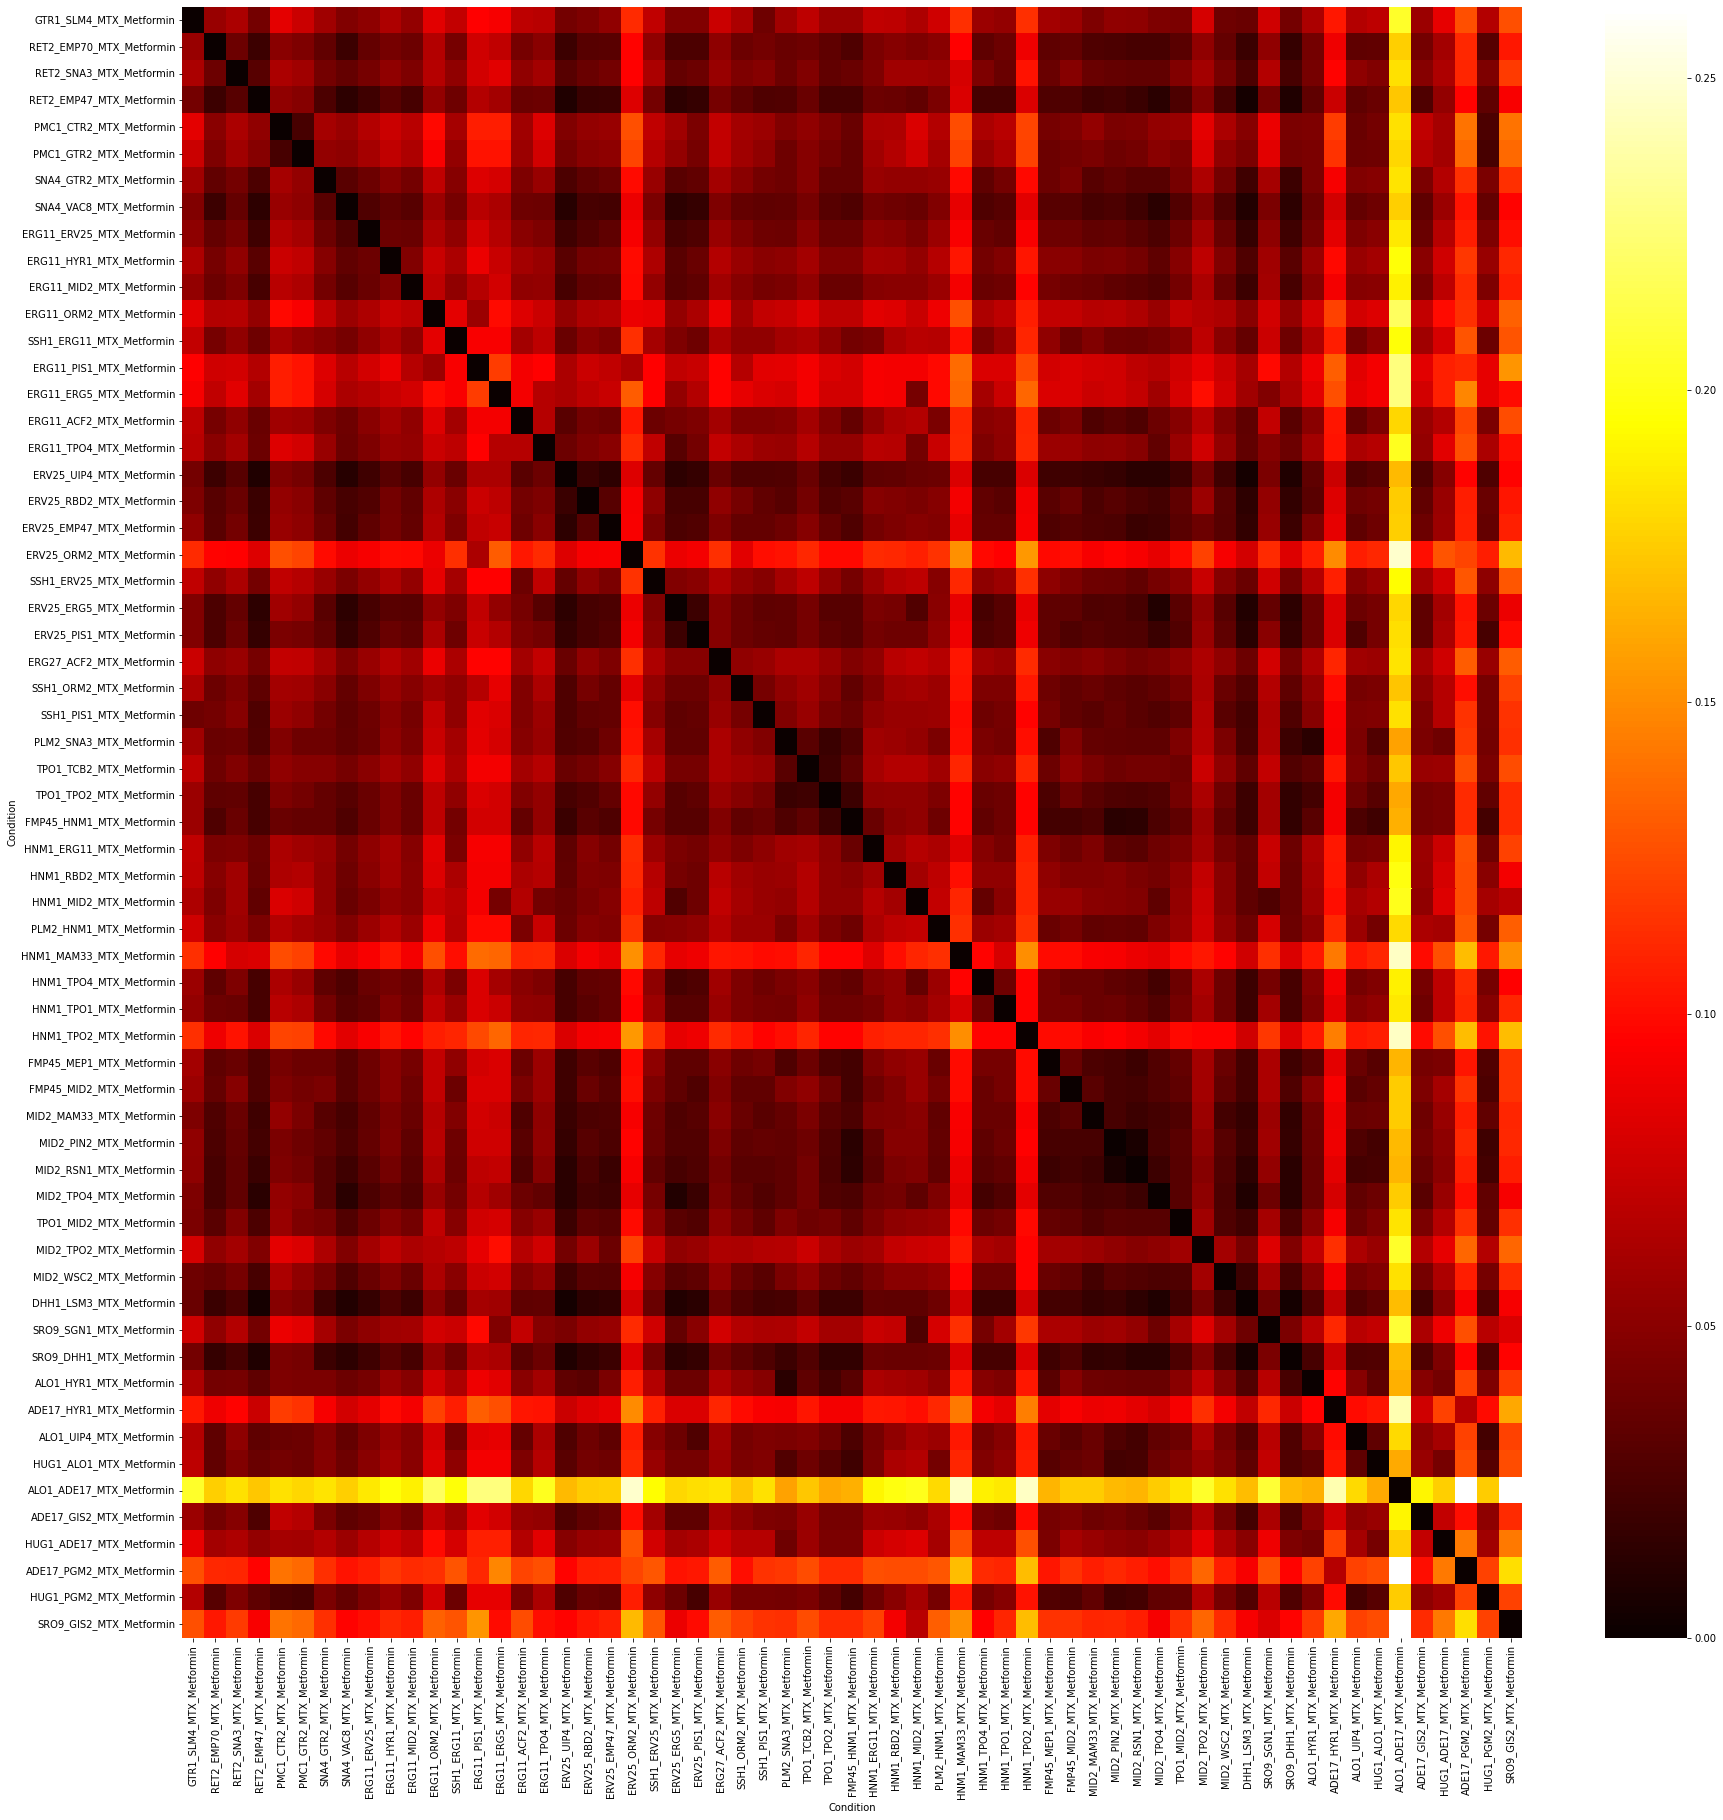

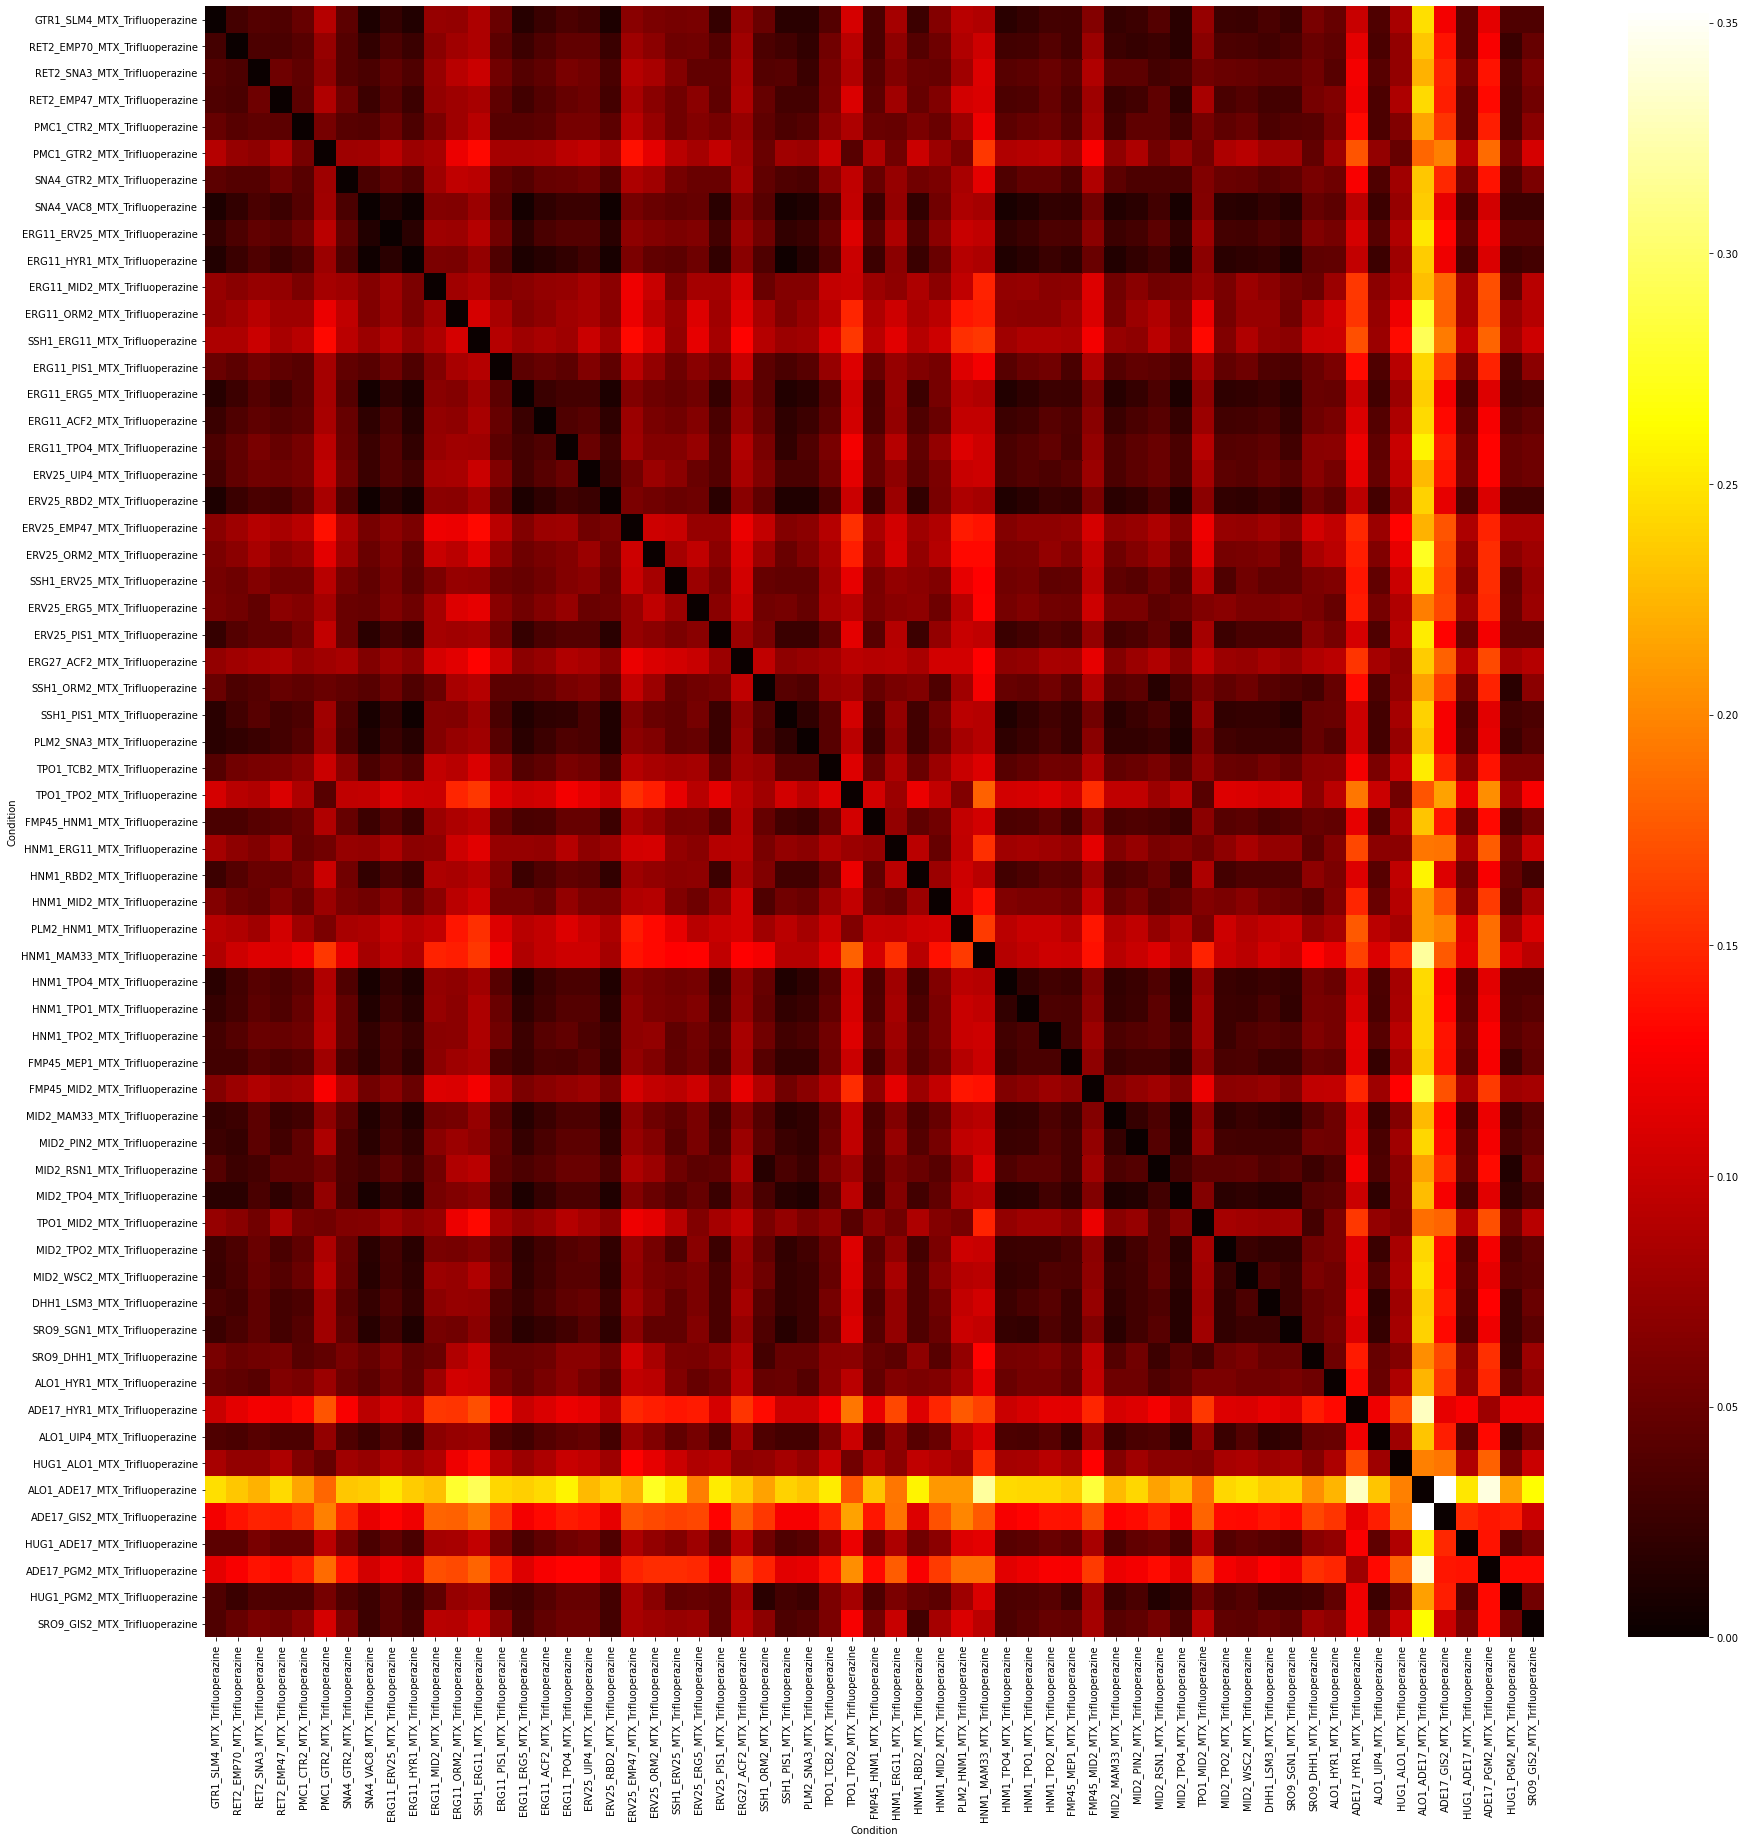

In [ ]:
DRUG_HEATMAPs = []
for DRUG in ['noDrug', '5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine']:
    DRUG_HEATMAP = piQTL_QTLs[piQTL_QTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)
    DRUG_HEATMAP = DRUG_HEATMAP.loc[([ True for i in range(len(DRUG_HEATMAP))]), (DRUG_HEATMAP.sum(axis=0) != 0)]

    PPI_order = []
    for PPI in piQTLs.index[g.dendrogram_row.reordered_ind]:
        if PPI in ppi['ppi'].values :
            PPI_order.append(f"{PPI.replace(':','_')}_MTX_{DRUG}")
        else : 
            PPI_order.append(f"{PPI.split(':')[1]}:{PPI.split(':')[0]}_MTX_{DRUG}".replace(':','_'))

    # print(PPI_order)

    DRUG_HEATMAP = DRUG_HEATMAP[DRUG_HEATMAP['Condition'].isin(PPI_order)]
    DRUG_HEATMAP['Condition'] = DRUG_HEATMAP['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order))
    DRUG_HEATMAP = DRUG_HEATMAP.sort_values("Condition").reset_index(drop=True)

    display(DRUG_HEATMAP.shape)

    DRUG_hamming = pd.DataFrame(
        squareform(pdist(DRUG_HEATMAP.set_index('Condition'), metric='hamming')),
        columns = DRUG_HEATMAP.set_index('Condition').index,
        index = DRUG_HEATMAP.set_index('Condition').index
    )

    # A = piQTLs.loc[piQTLs.index[g.dendrogram_row.reordered_ind], piQTLs.index[g.dendrogram_row.reordered_ind]].stack()
    # B = DRUG_hamming.stack()

    # RES = pd.DataFrame([ (A.values[i], B.values[i]) for i in range(len(A)) ], columns=['PPI_distance', 'piQTL_similarity'])

    # sns.scatterplot(x=RES['PPI_distance'], y=RES['piQTL_similarity'])
    # print(stats.spearmanr(RES['PPI_distance'], RES['piQTL_similarity']))
    # plt.title(DRUG)
    # plt.show()
    f = plt.figure(figsize=(30,30))
    sns.heatmap(DRUG_hamming, cmap='hot', xticklabels=True, yticklabels=True)
    f.savefig(f"{root_path}/figures/supp_figures/distance_heatmap_PPI_distance_manhattan_{DRUG}.png", dpi=300)
    f.savefig(f"{root_path}/figures/supp_figures/distance_heatmap_PPI_distance_manhattan_{DRUG}.eps", dpi=300)


/tmp/ipykernel_89510/3135098874.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRUG_HEATMAP['Condition'] = DRUG_HEATMAP['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order))


(61, 302)

/tmp/ipykernel_89510/3135098874.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRUG_HEATMAP['Condition'] = DRUG_HEATMAP['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order))


(61, 653)

/tmp/ipykernel_89510/3135098874.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRUG_HEATMAP['Condition'] = DRUG_HEATMAP['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order))


(61, 519)

/tmp/ipykernel_89510/3135098874.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRUG_HEATMAP['Condition'] = DRUG_HEATMAP['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order))


(61, 296)

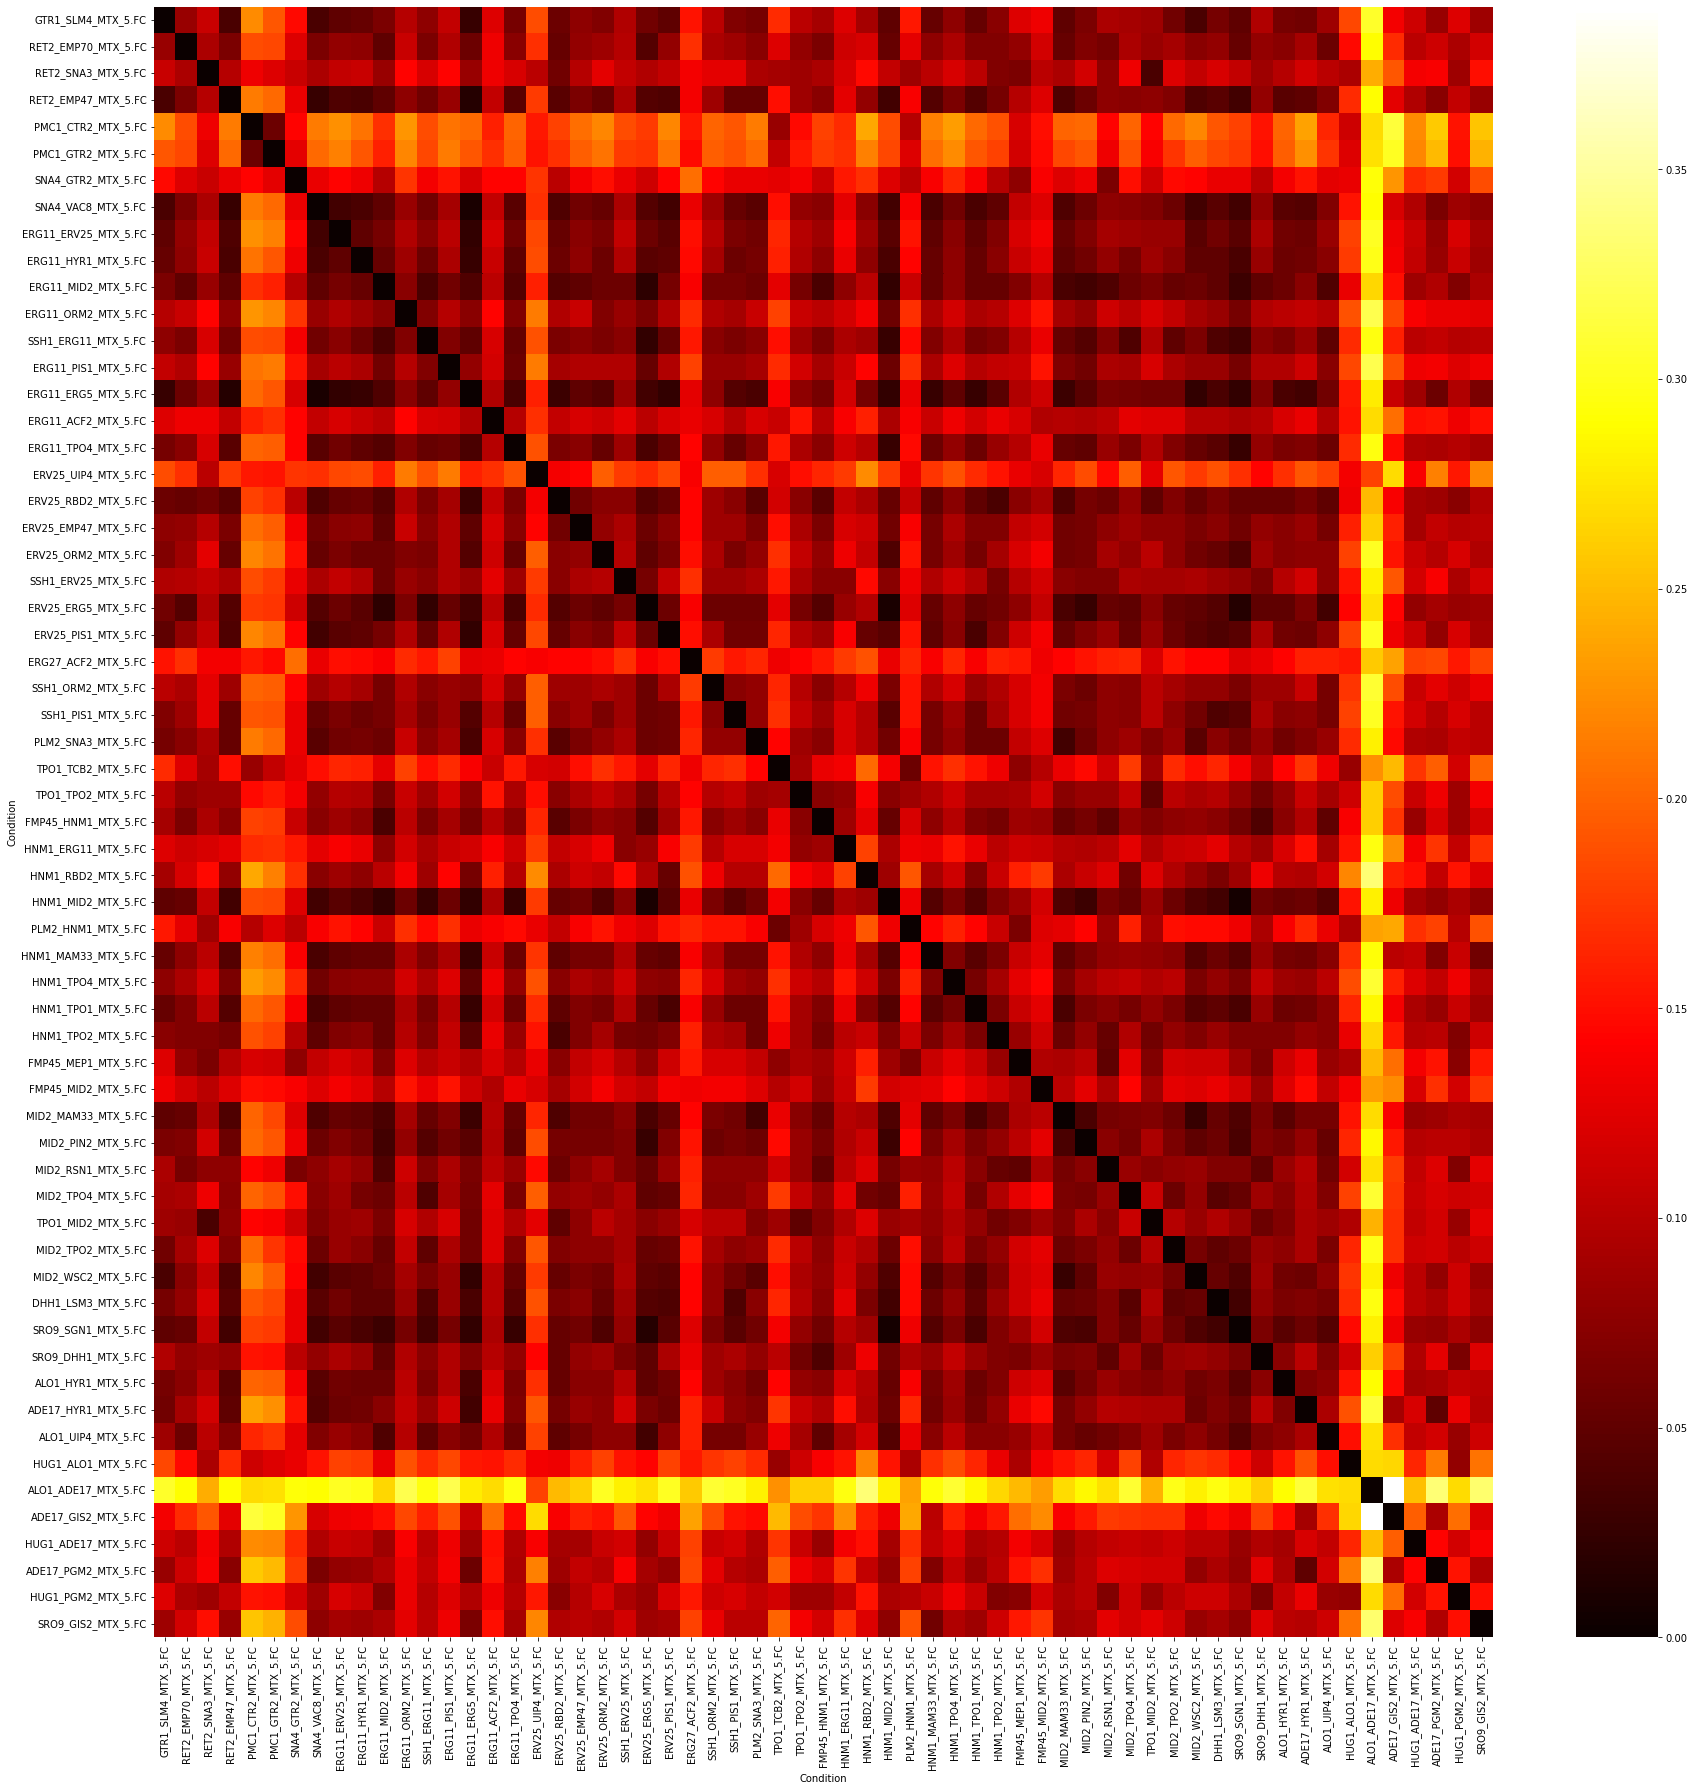

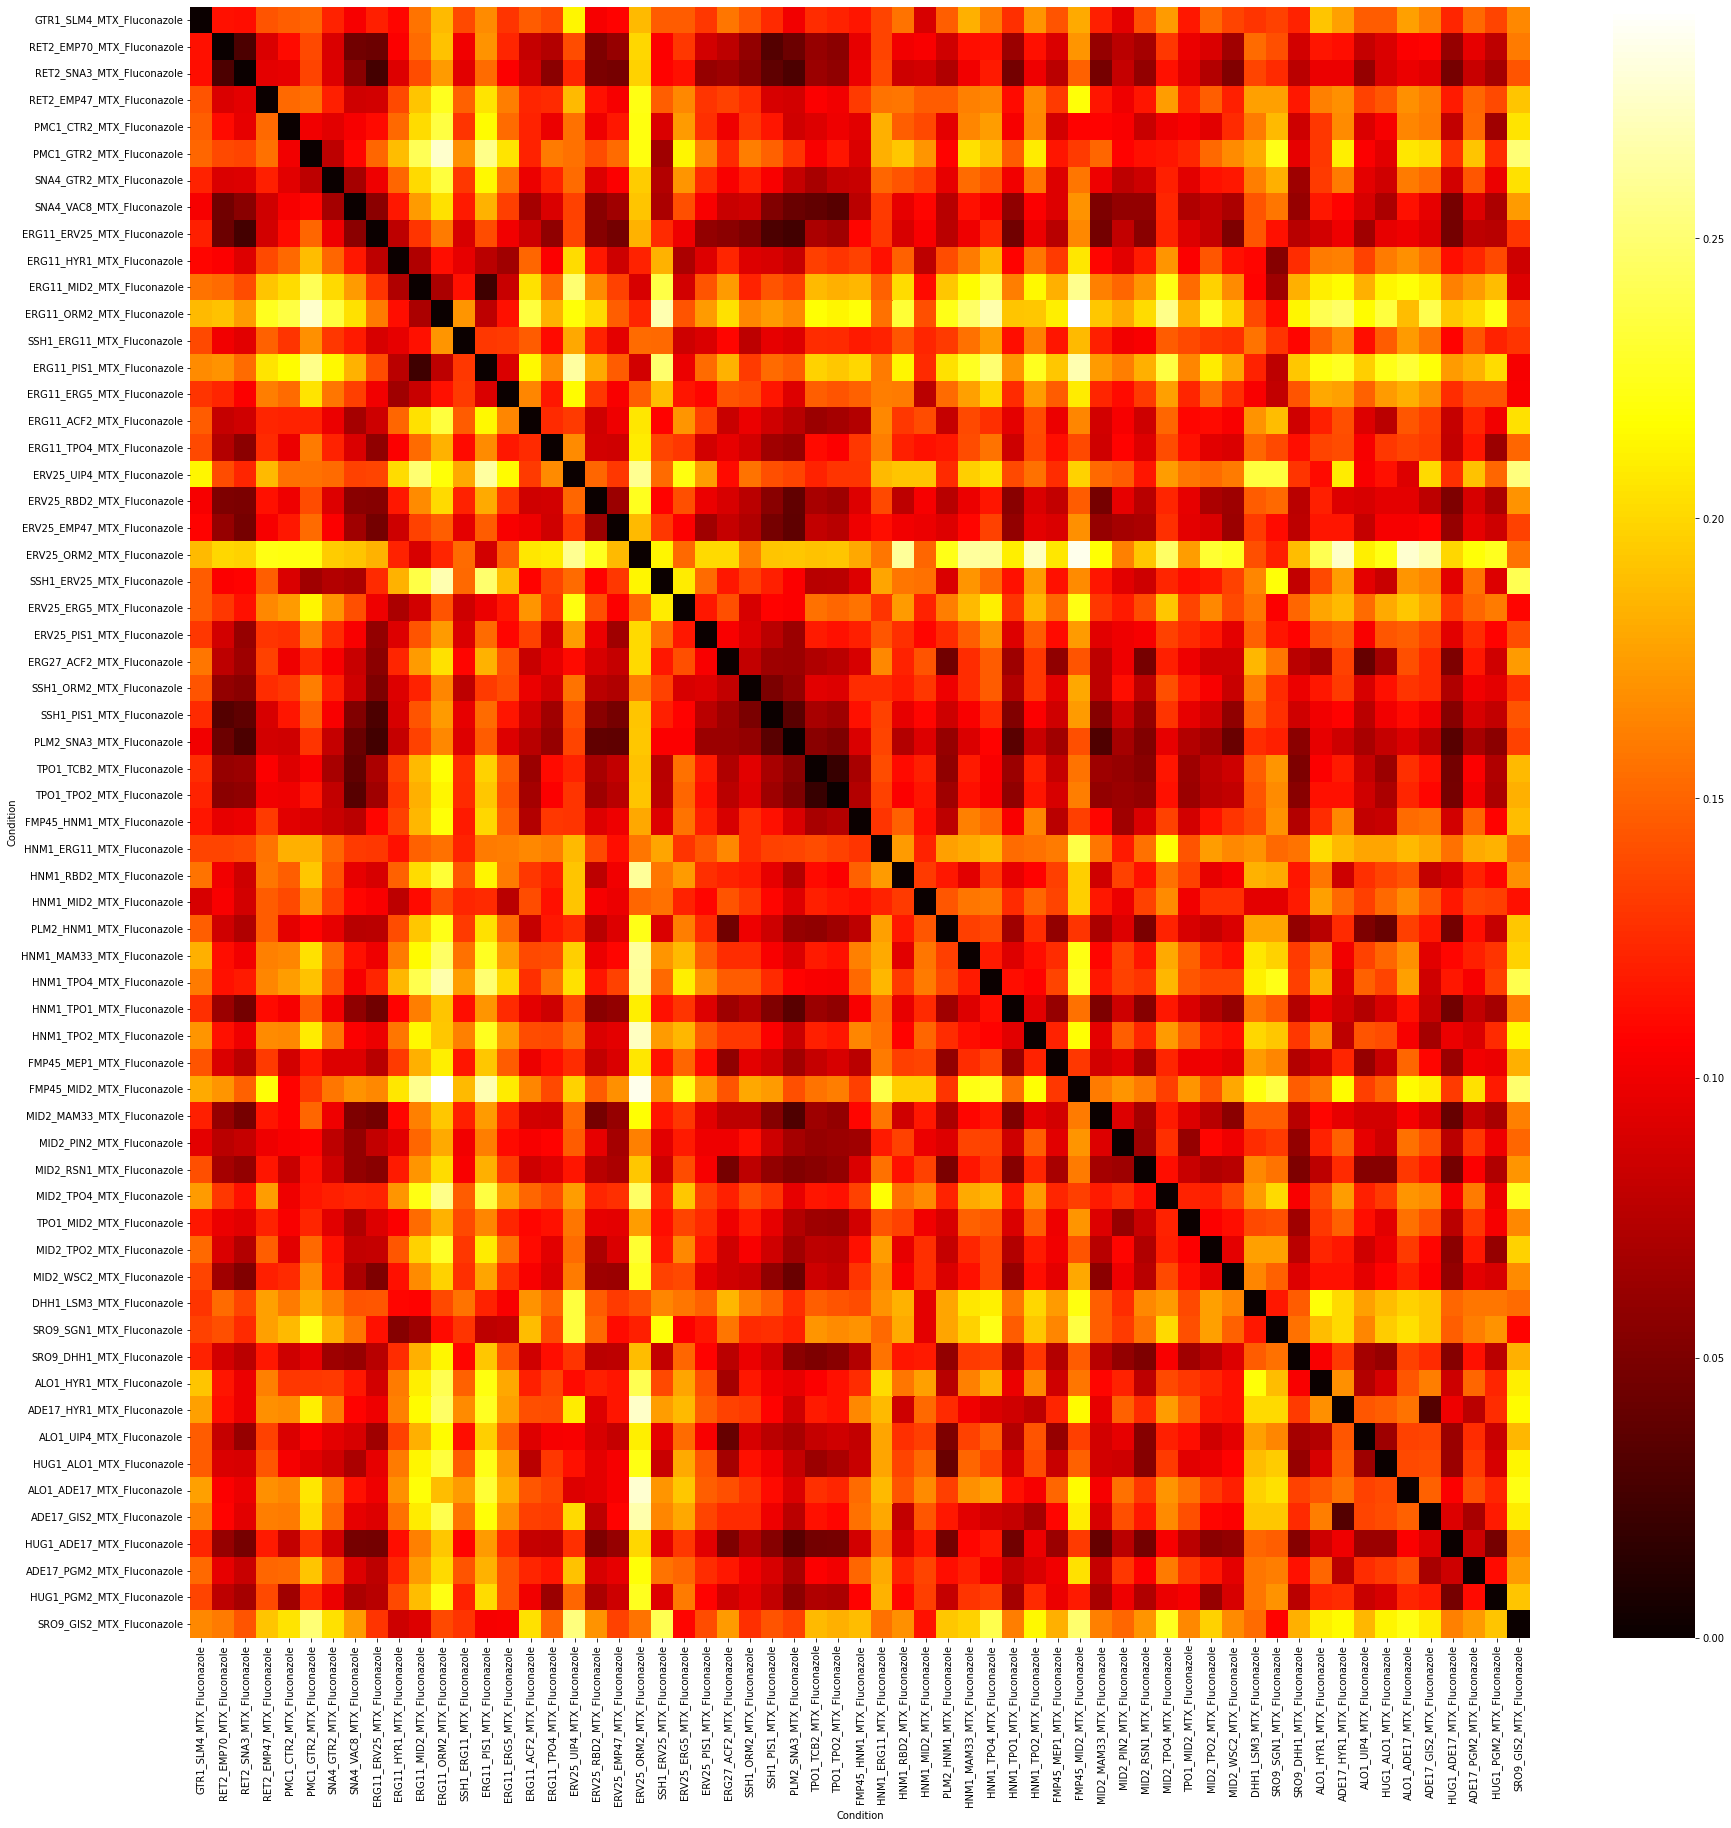

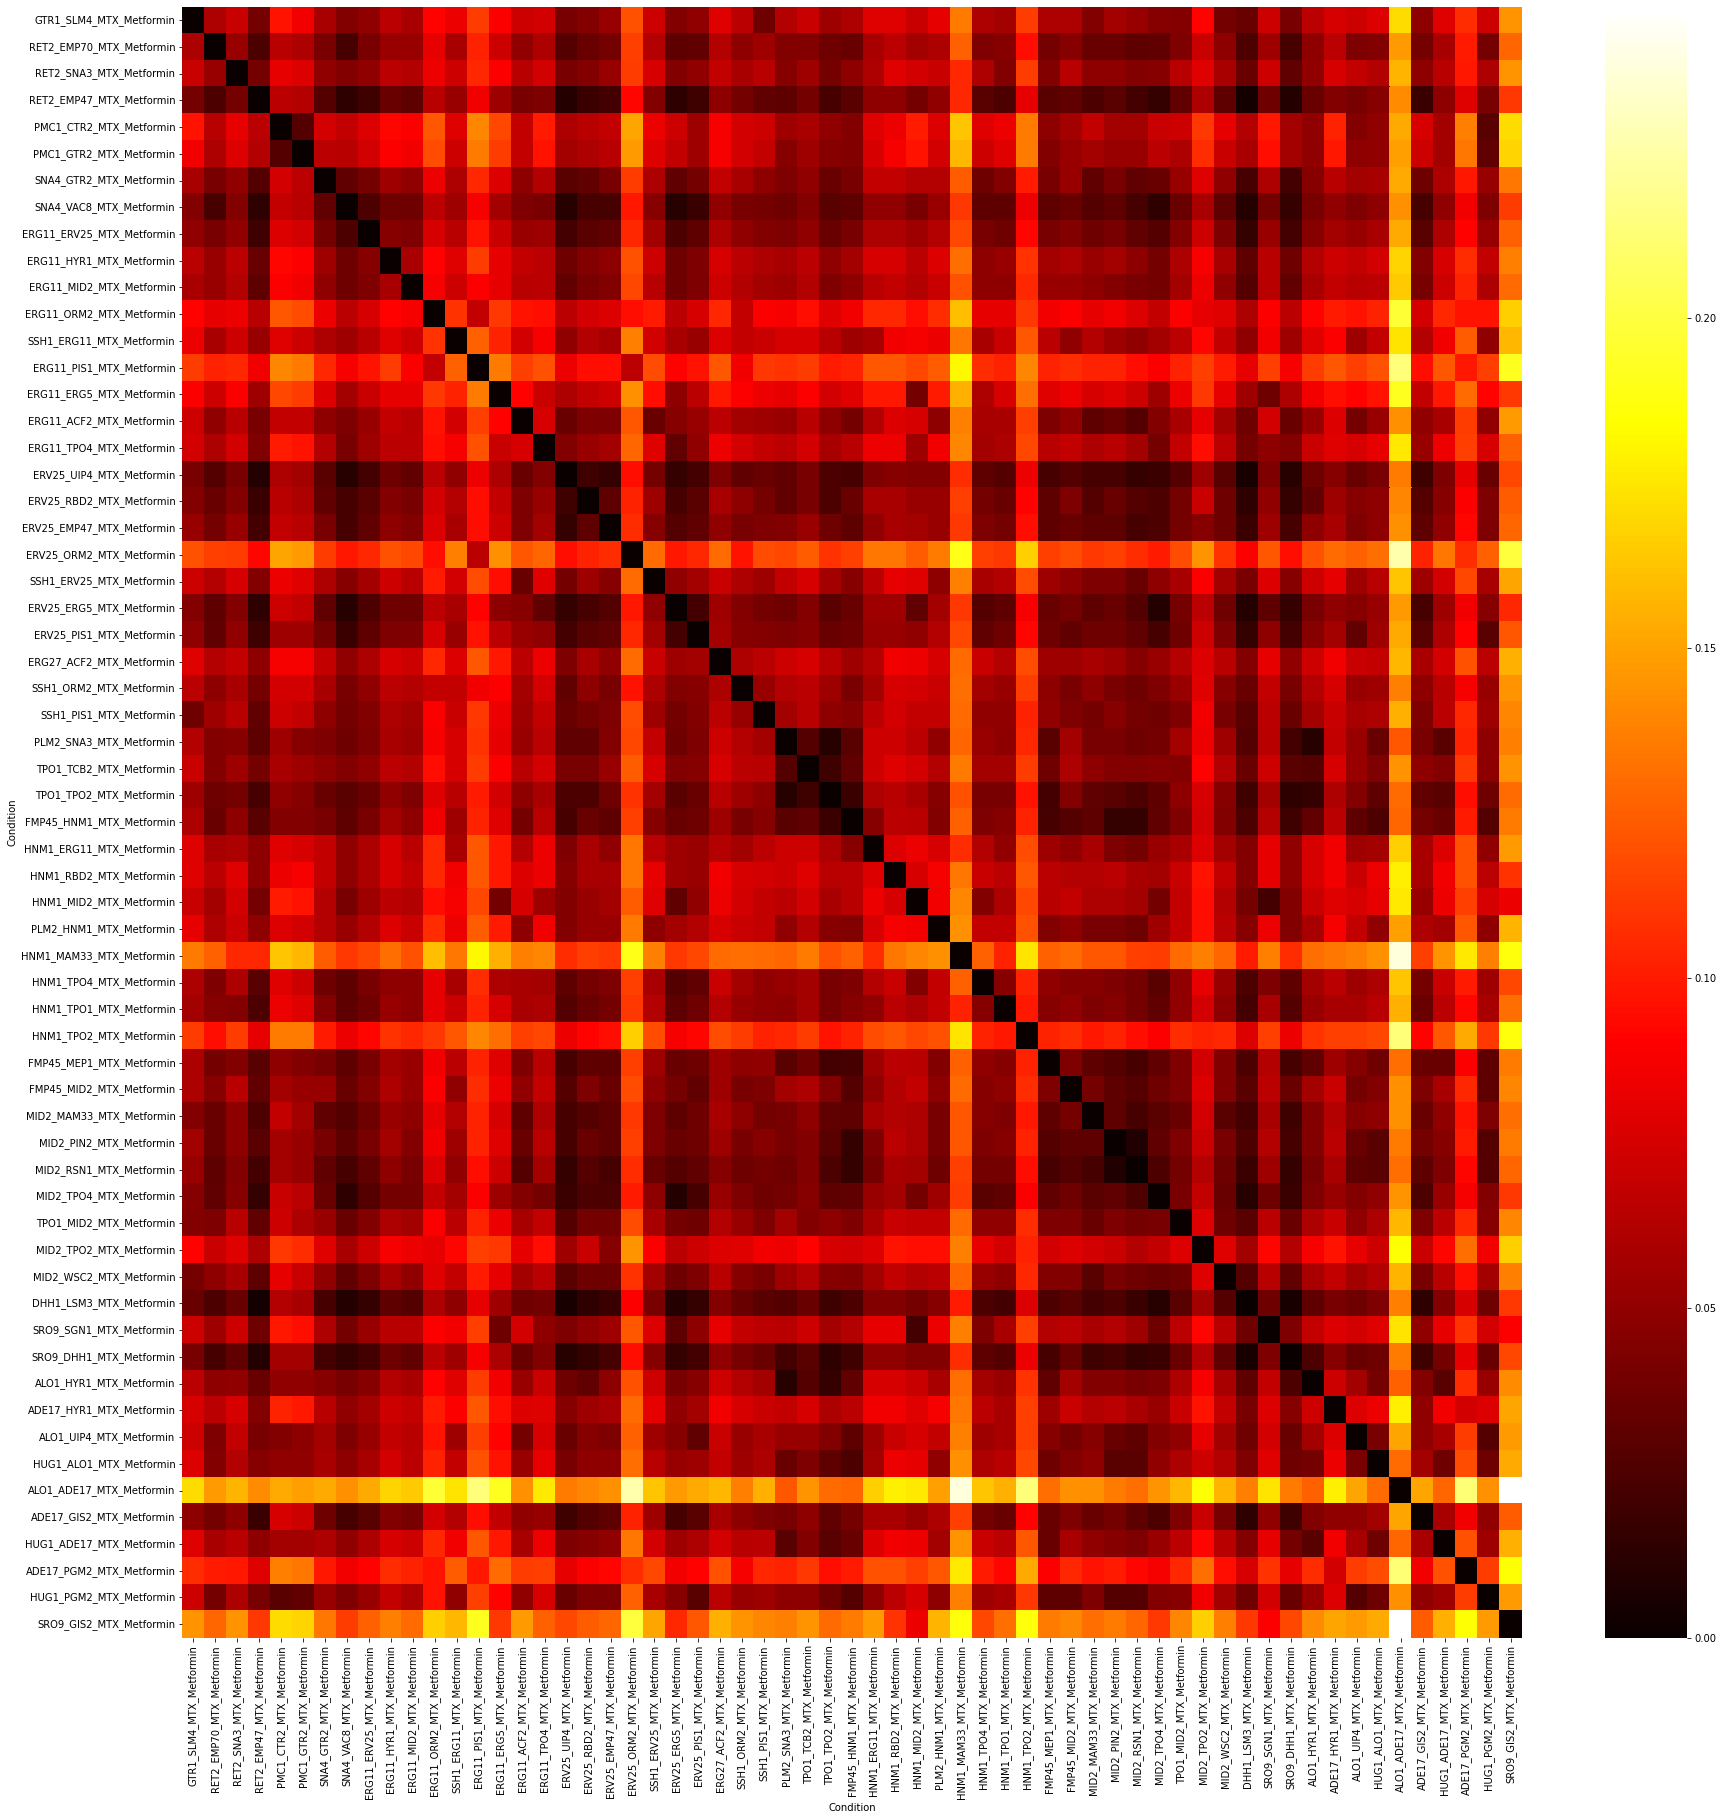

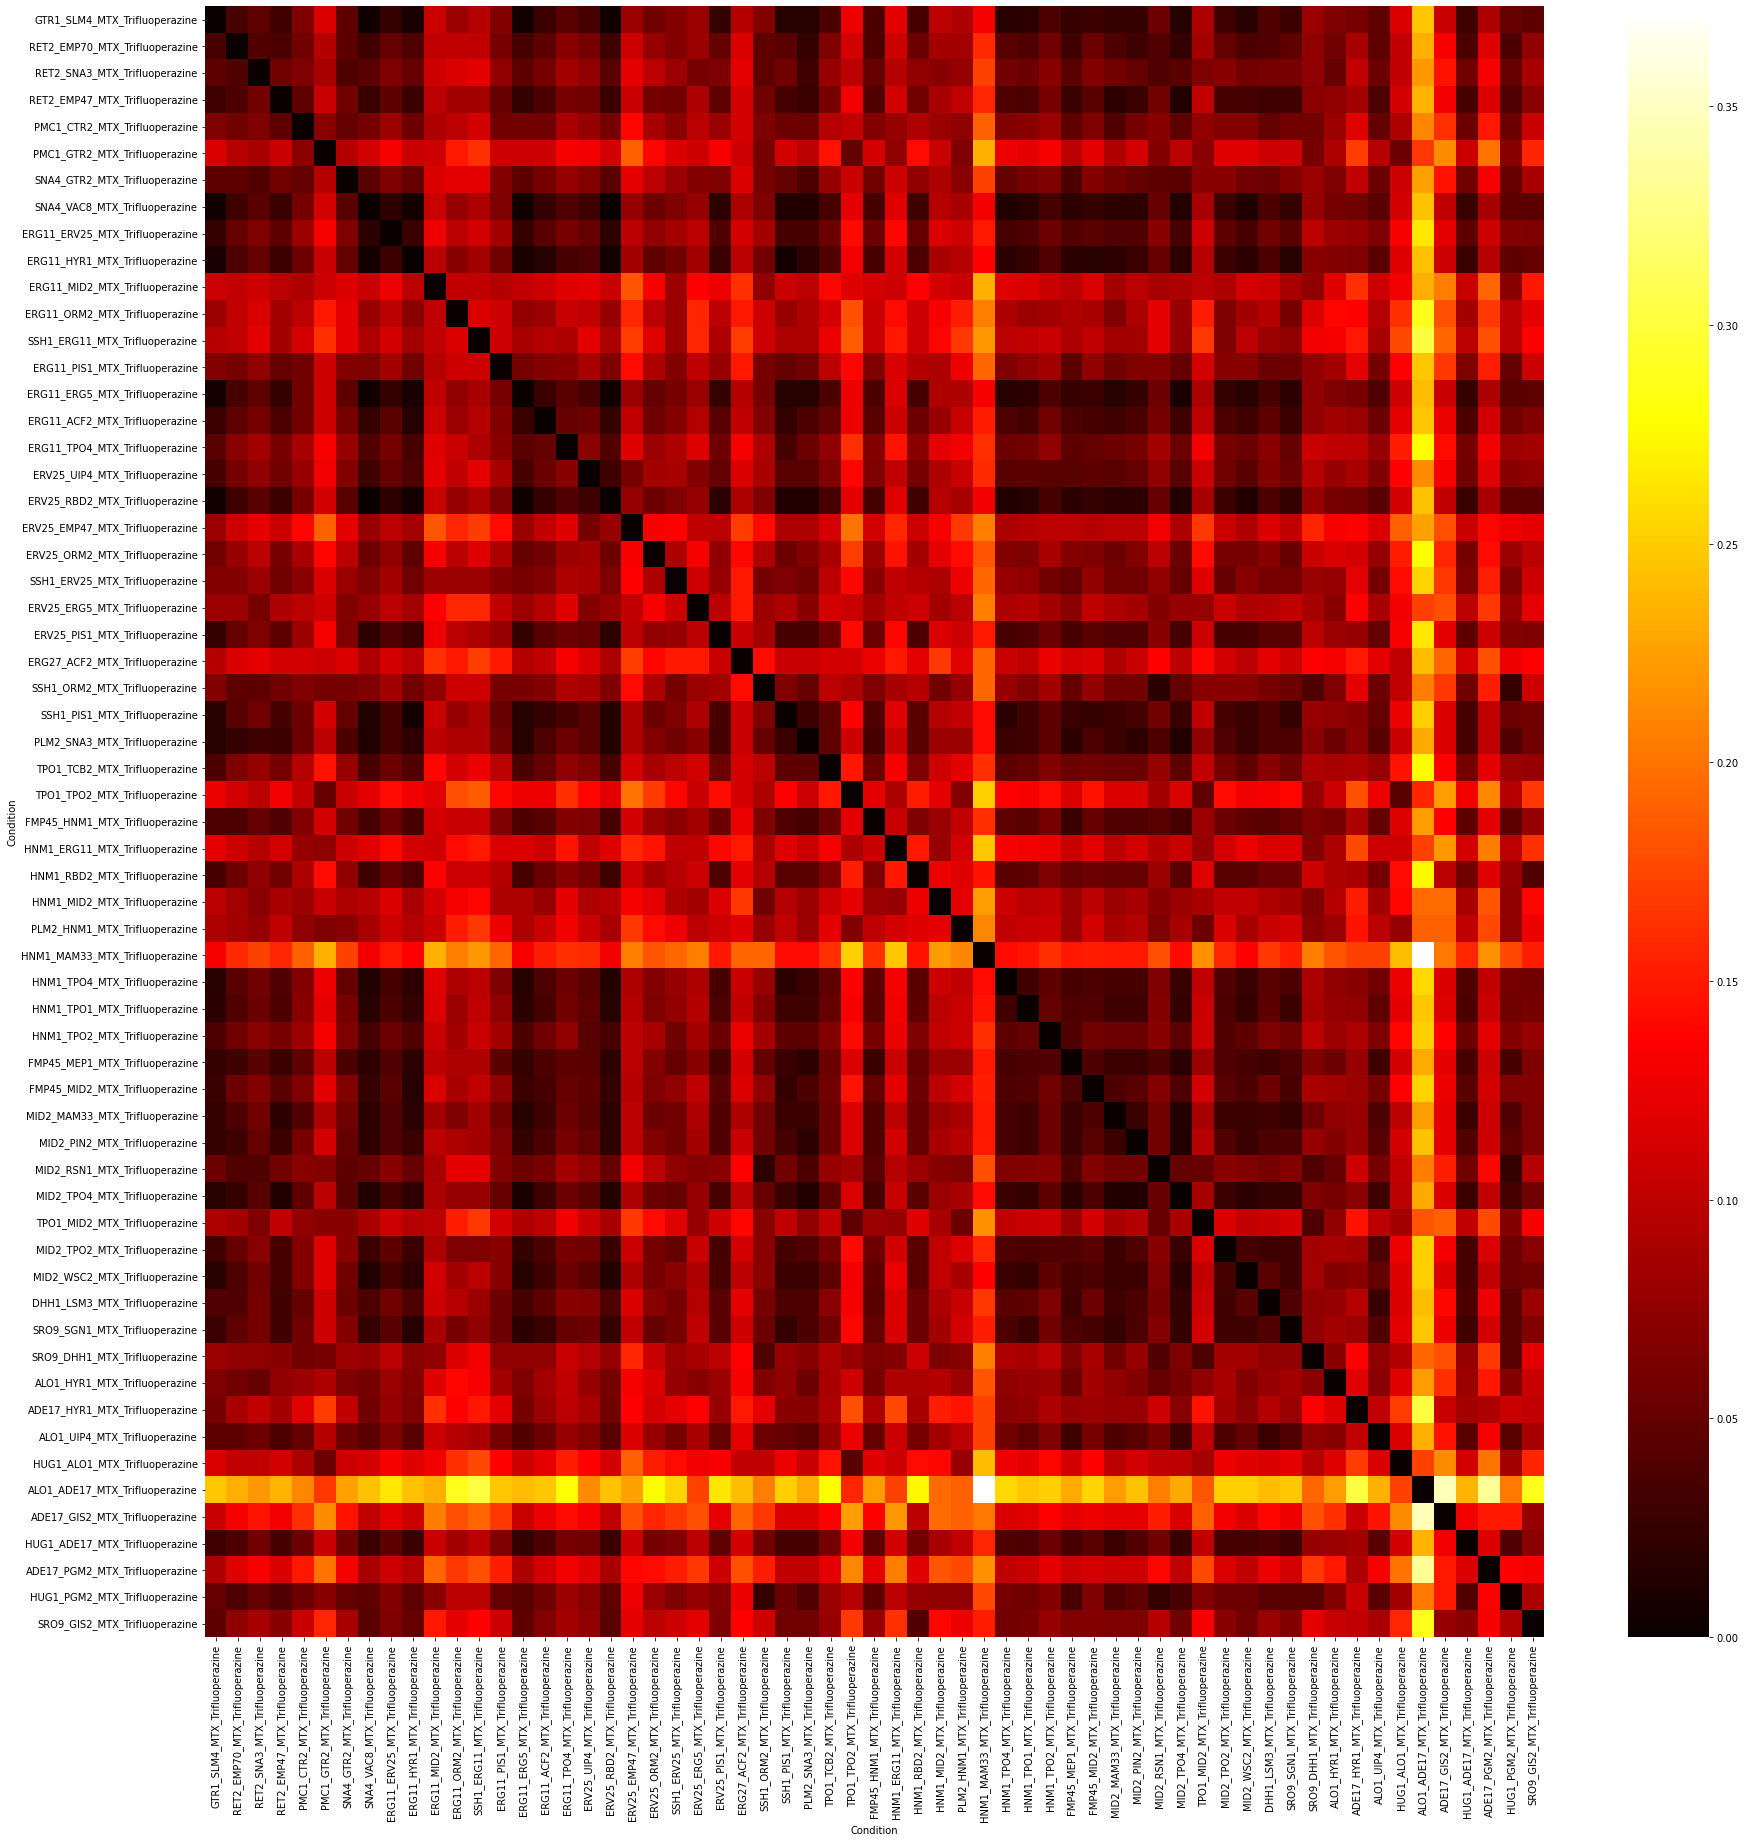

In [ ]:
DRUG_HEATMAPs = []
for DRUG in ['5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine']:
    ES_piQTLs = pd.read_csv(f'{root_path}/results/05_piQTL_tables/ES_vs_NES/{DRUG}_ES_piQTLs.csv').sort_values('SNP')
    ES_piQTLs['SNP_ID'] = [ f'CHR{ES_piQTLs["Chr"][idx]}_{ES_piQTLs["SNP"][idx]}'.replace('CHRMT_', 'CHR17_') for idx in ES_piQTLs.index ]
    ES_piQTLs_IDs = ES_piQTLs[~ES_piQTLs['SNP_ID'].str.contains('CHR0')]['SNP_ID'].unique()
    ES_piQTLs_IDs = list(ES_piQTLs_IDs)
    ES_piQTLs_IDs.insert(0,'Condition')
    DRUG_HEATMAP = piQTL_QTLs[piQTL_QTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)

    PPI_order = []
    for PPI in piQTLs.index[g.dendrogram_row.reordered_ind]:
        if PPI in ppi['ppi'].values :
            PPI_order.append(f"{PPI.replace(':','_')}_MTX_{DRUG}")
        else : 
            PPI_order.append(f"{PPI.split(':')[1]}:{PPI.split(':')[0]}_MTX_{DRUG}".replace(':','_'))

    # print(PPI_order)

    DRUG_HEATMAP = piQTL_QTLs[piQTL_QTLs['Condition'].isin(PPI_order)]
    DRUG_HEATMAP['Condition'] = DRUG_HEATMAP['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order))
    DRUG_HEATMAP = DRUG_HEATMAP.sort_values("Condition").reset_index(drop=True)
    DRUG_HEATMAP = DRUG_HEATMAP[ES_piQTLs_IDs]

    display(DRUG_HEATMAP.shape)

    DRUG_hamming = pd.DataFrame(
        squareform(pdist(DRUG_HEATMAP.set_index('Condition'), metric='hamming')),
        columns = DRUG_HEATMAP.set_index('Condition').index,
        index = DRUG_HEATMAP.set_index('Condition').index
    )

    # display(DRUG_hamming)

    f = plt.figure(figsize=(30,30))
    sns.heatmap(DRUG_hamming, cmap='hot', xticklabels=True, yticklabels=True)
    f.savefig(f"{root_path}/figures/supp_figures/distance_heatmap_PPI_distance_manhattan_{DRUG}_ES.png", dpi=300)


/tmp/ipykernel_89510/1768041119.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRUG_HEATMAP['Condition'] = DRUG_HEATMAP['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order))


(61, 262)

/tmp/ipykernel_89510/1768041119.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRUG_HEATMAP['Condition'] = DRUG_HEATMAP['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order))


(61, 193)

/tmp/ipykernel_89510/1768041119.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRUG_HEATMAP['Condition'] = DRUG_HEATMAP['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order))


(61, 223)

/tmp/ipykernel_89510/1768041119.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRUG_HEATMAP['Condition'] = DRUG_HEATMAP['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order))


(61, 287)

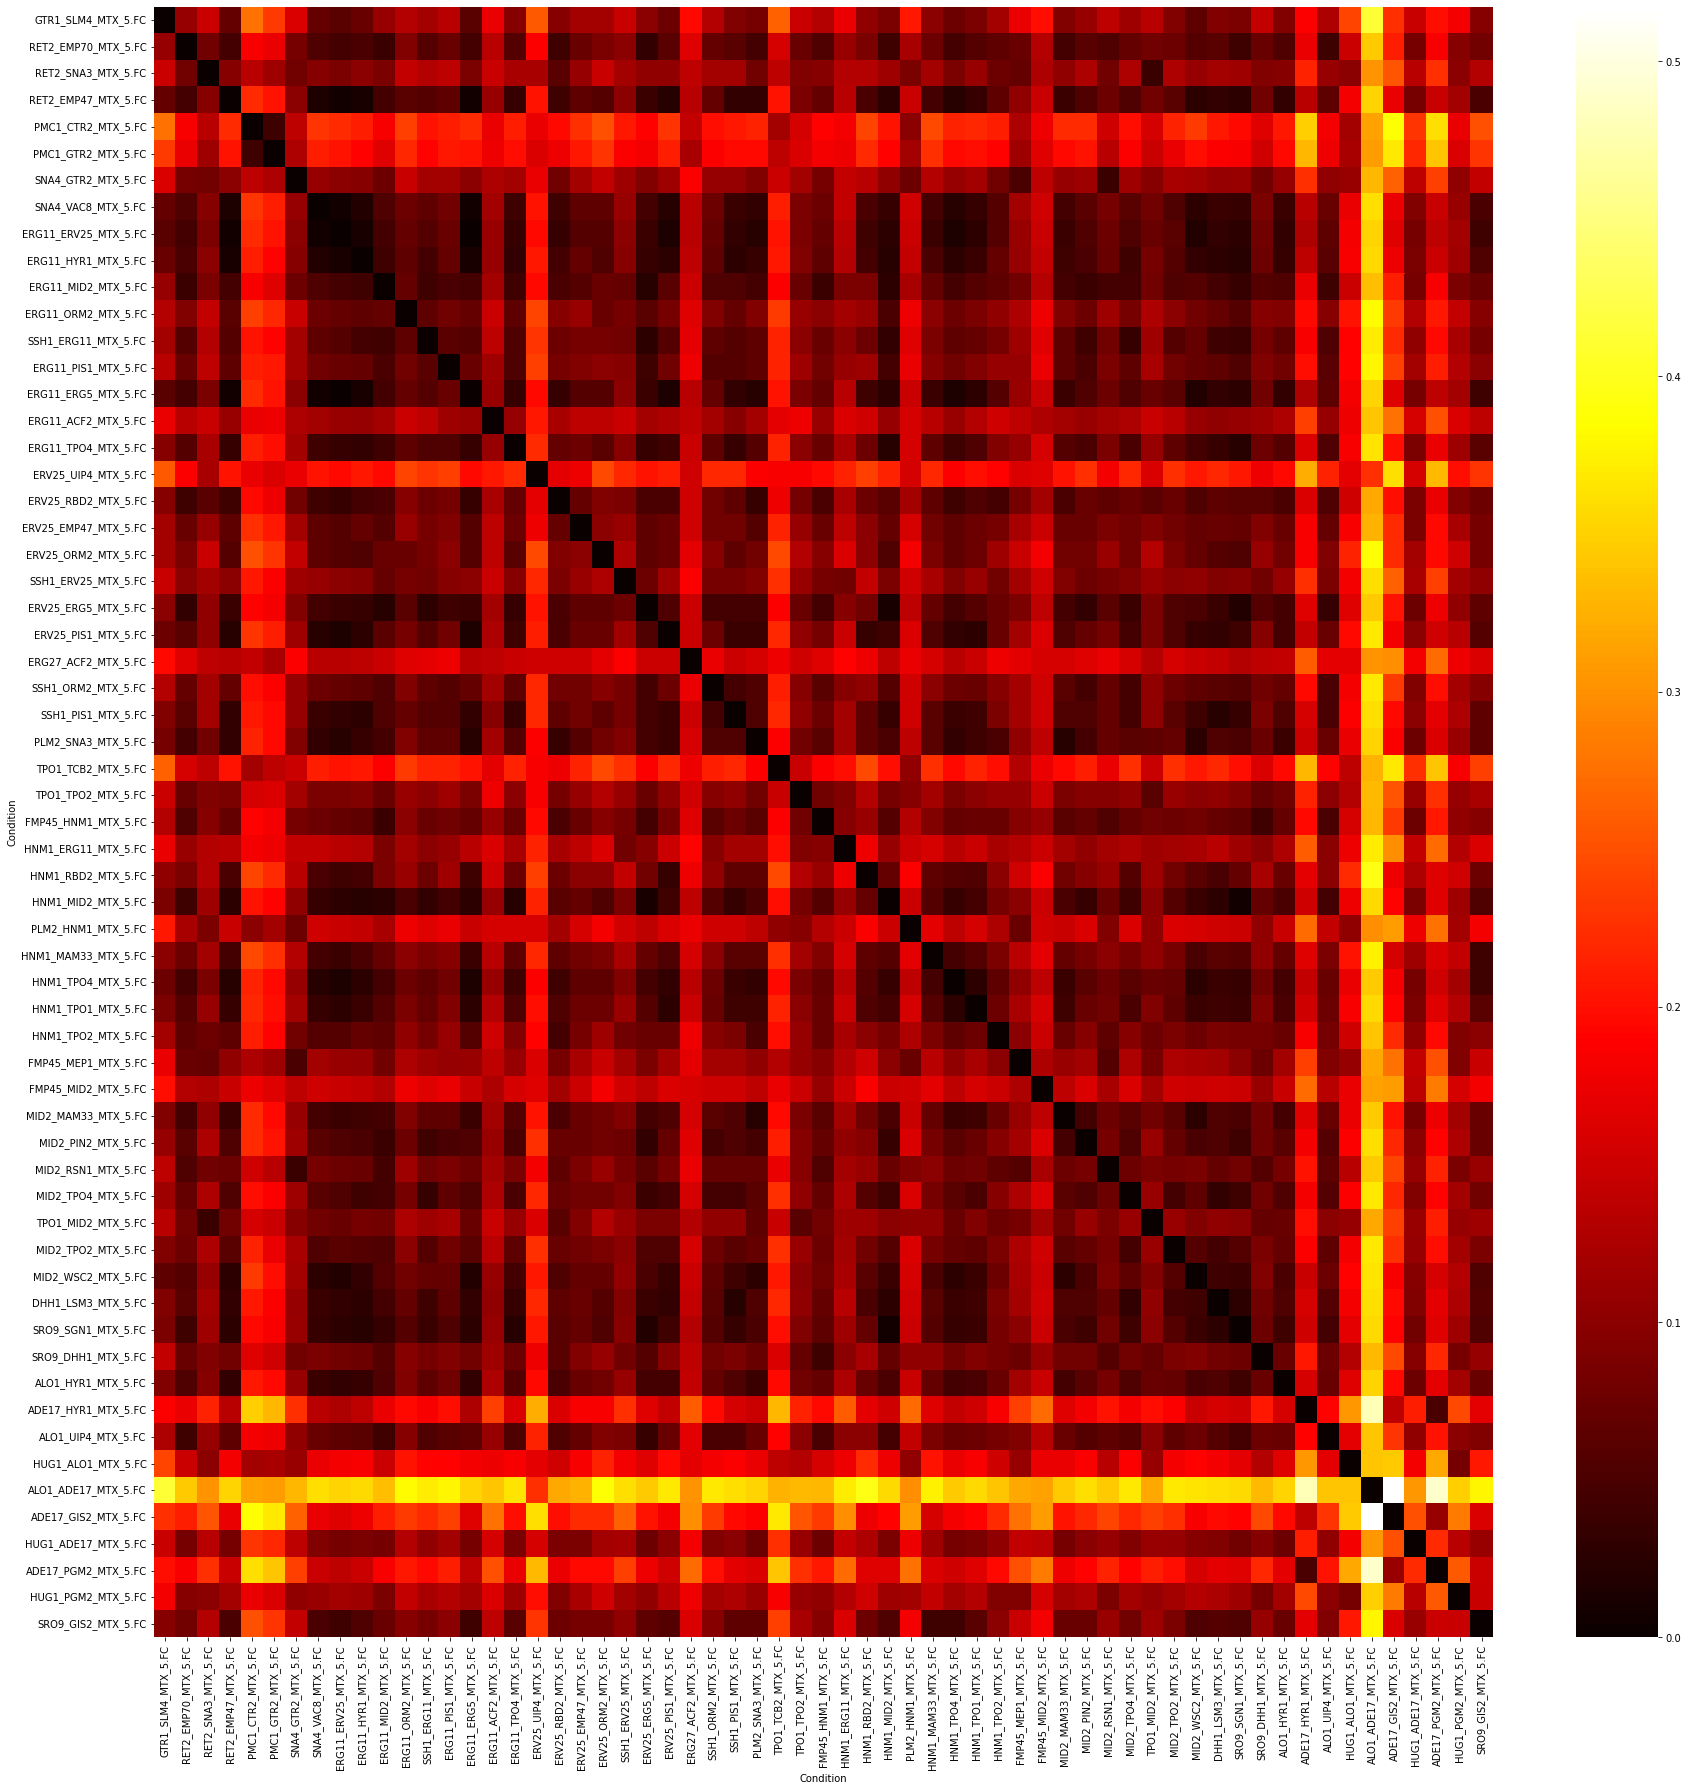

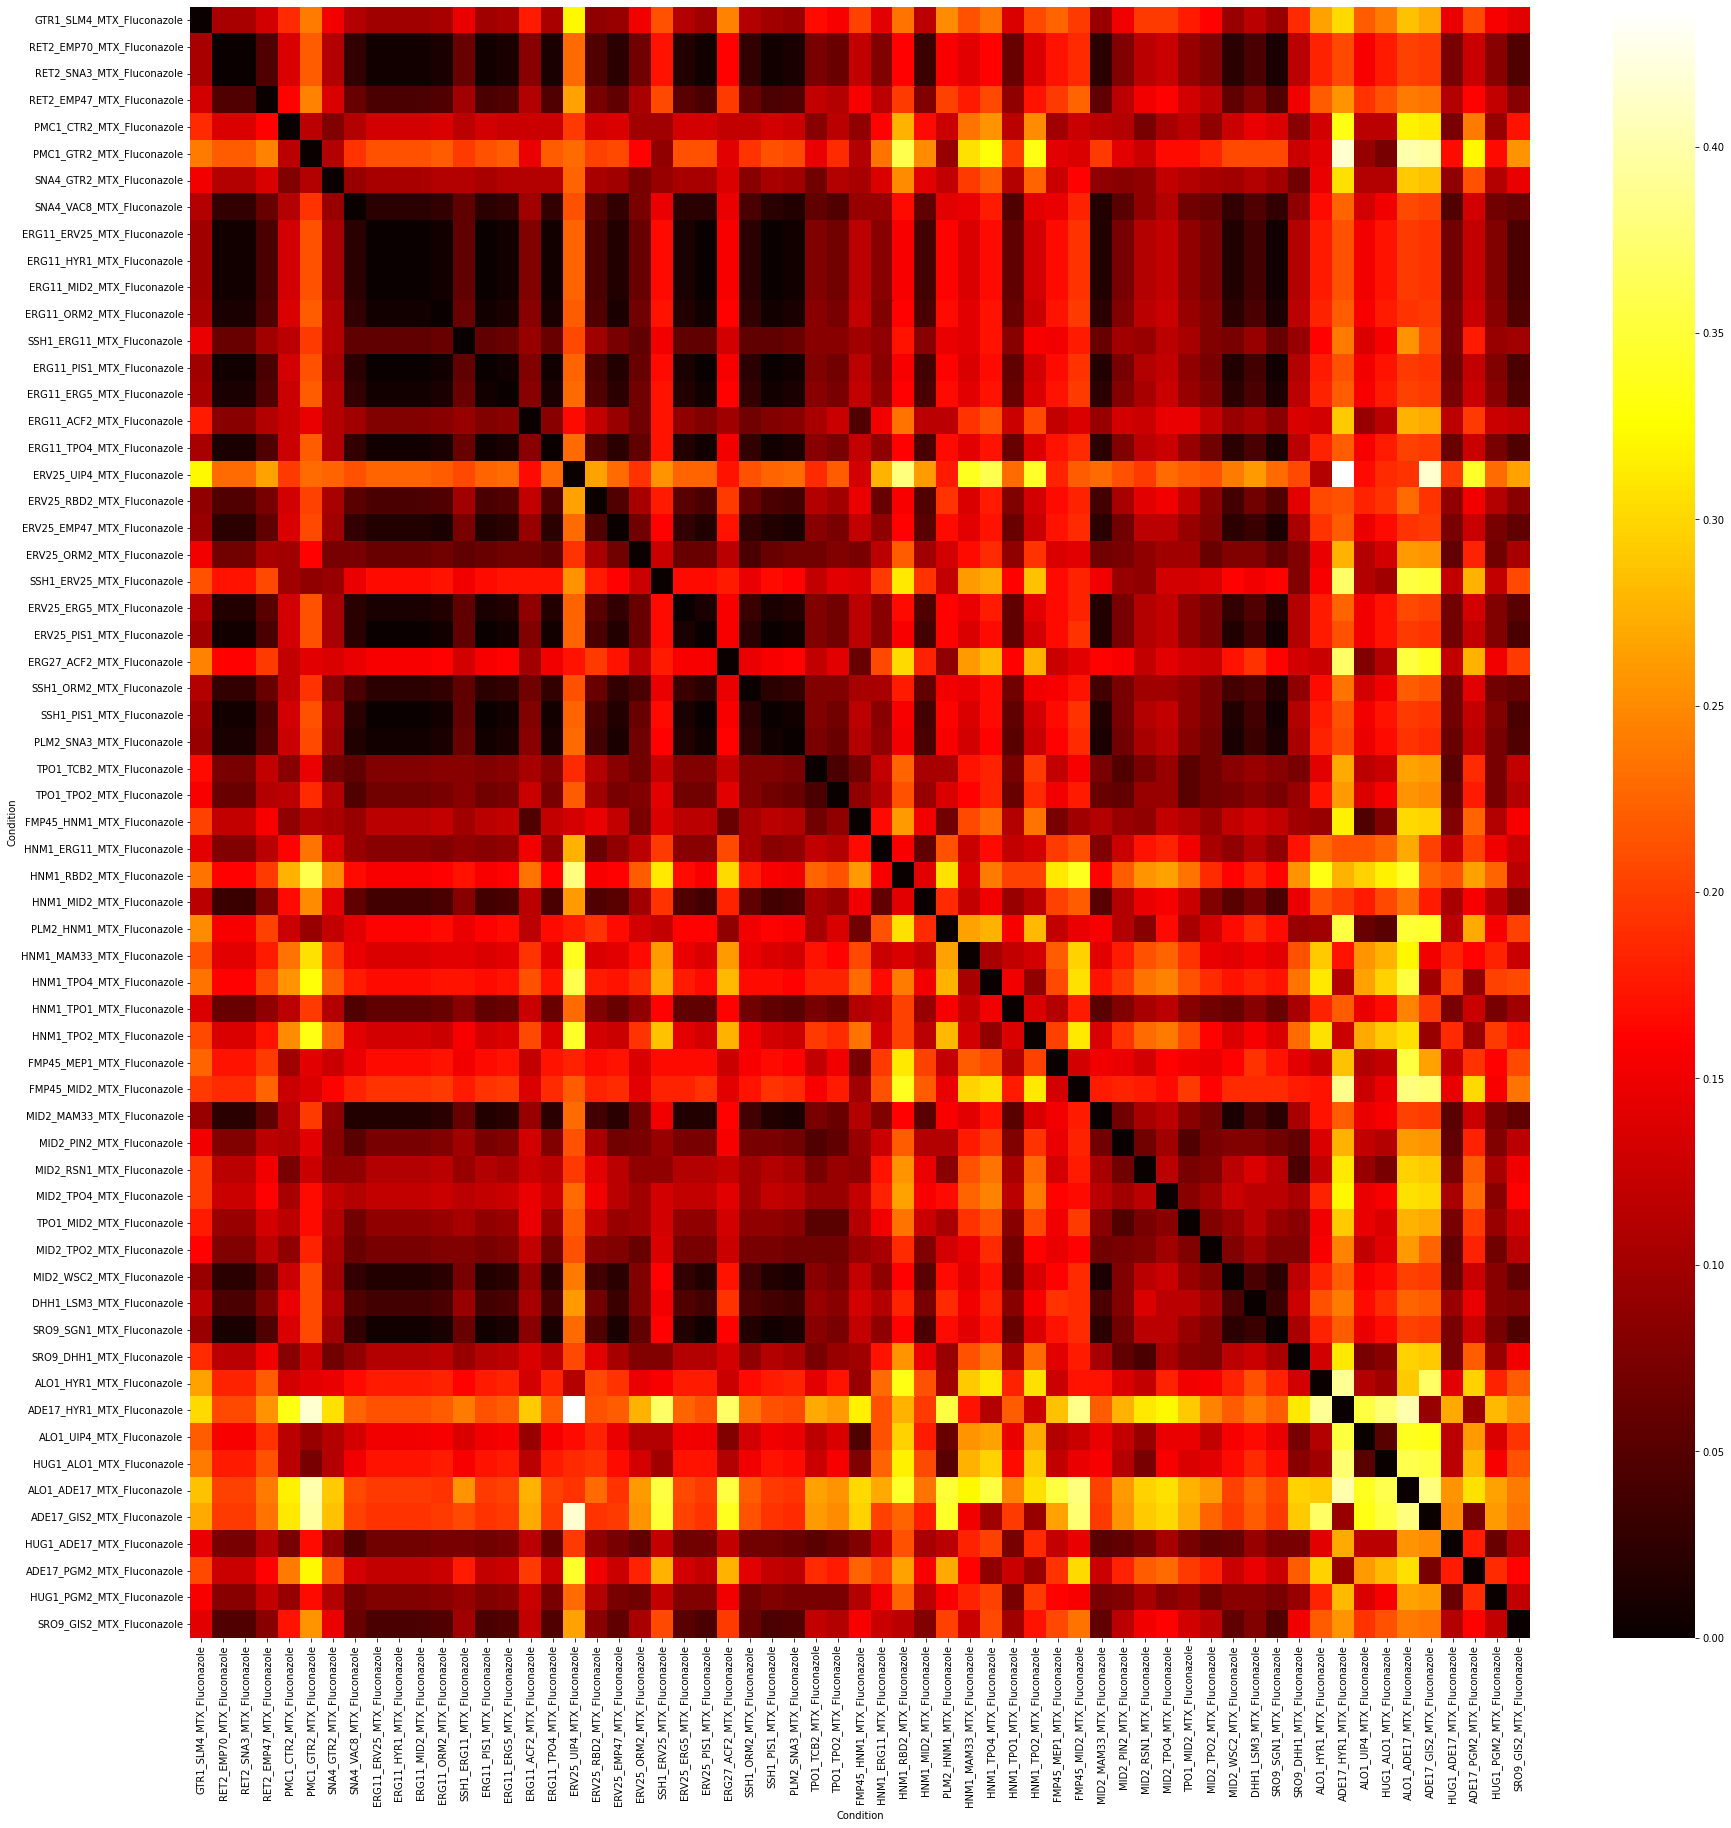

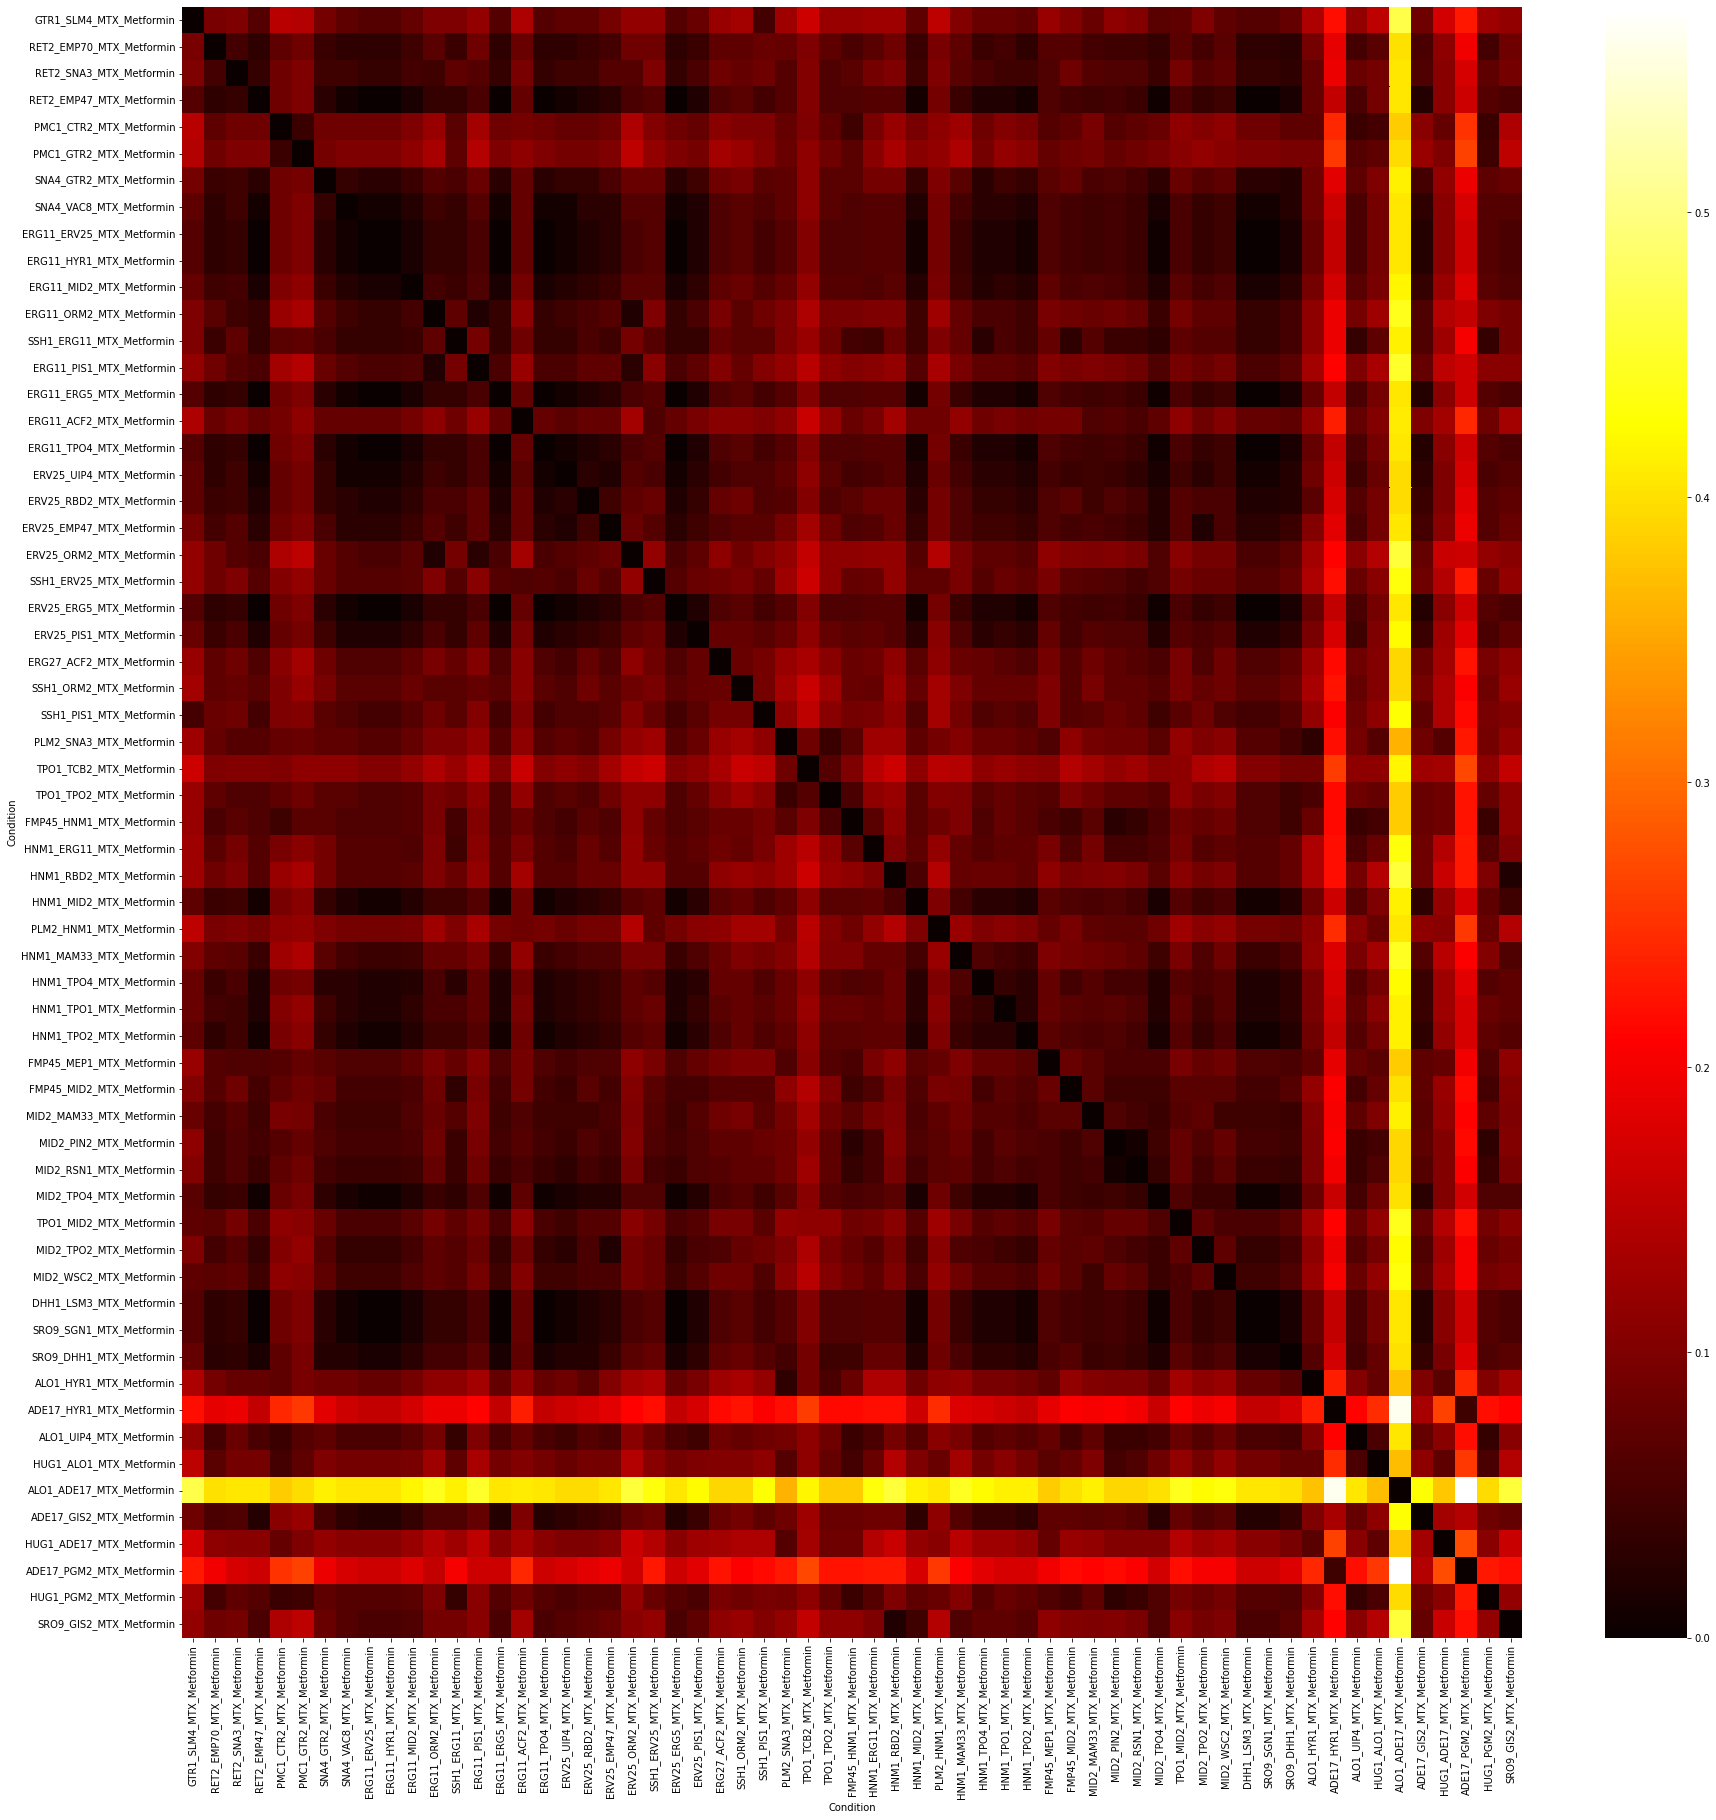

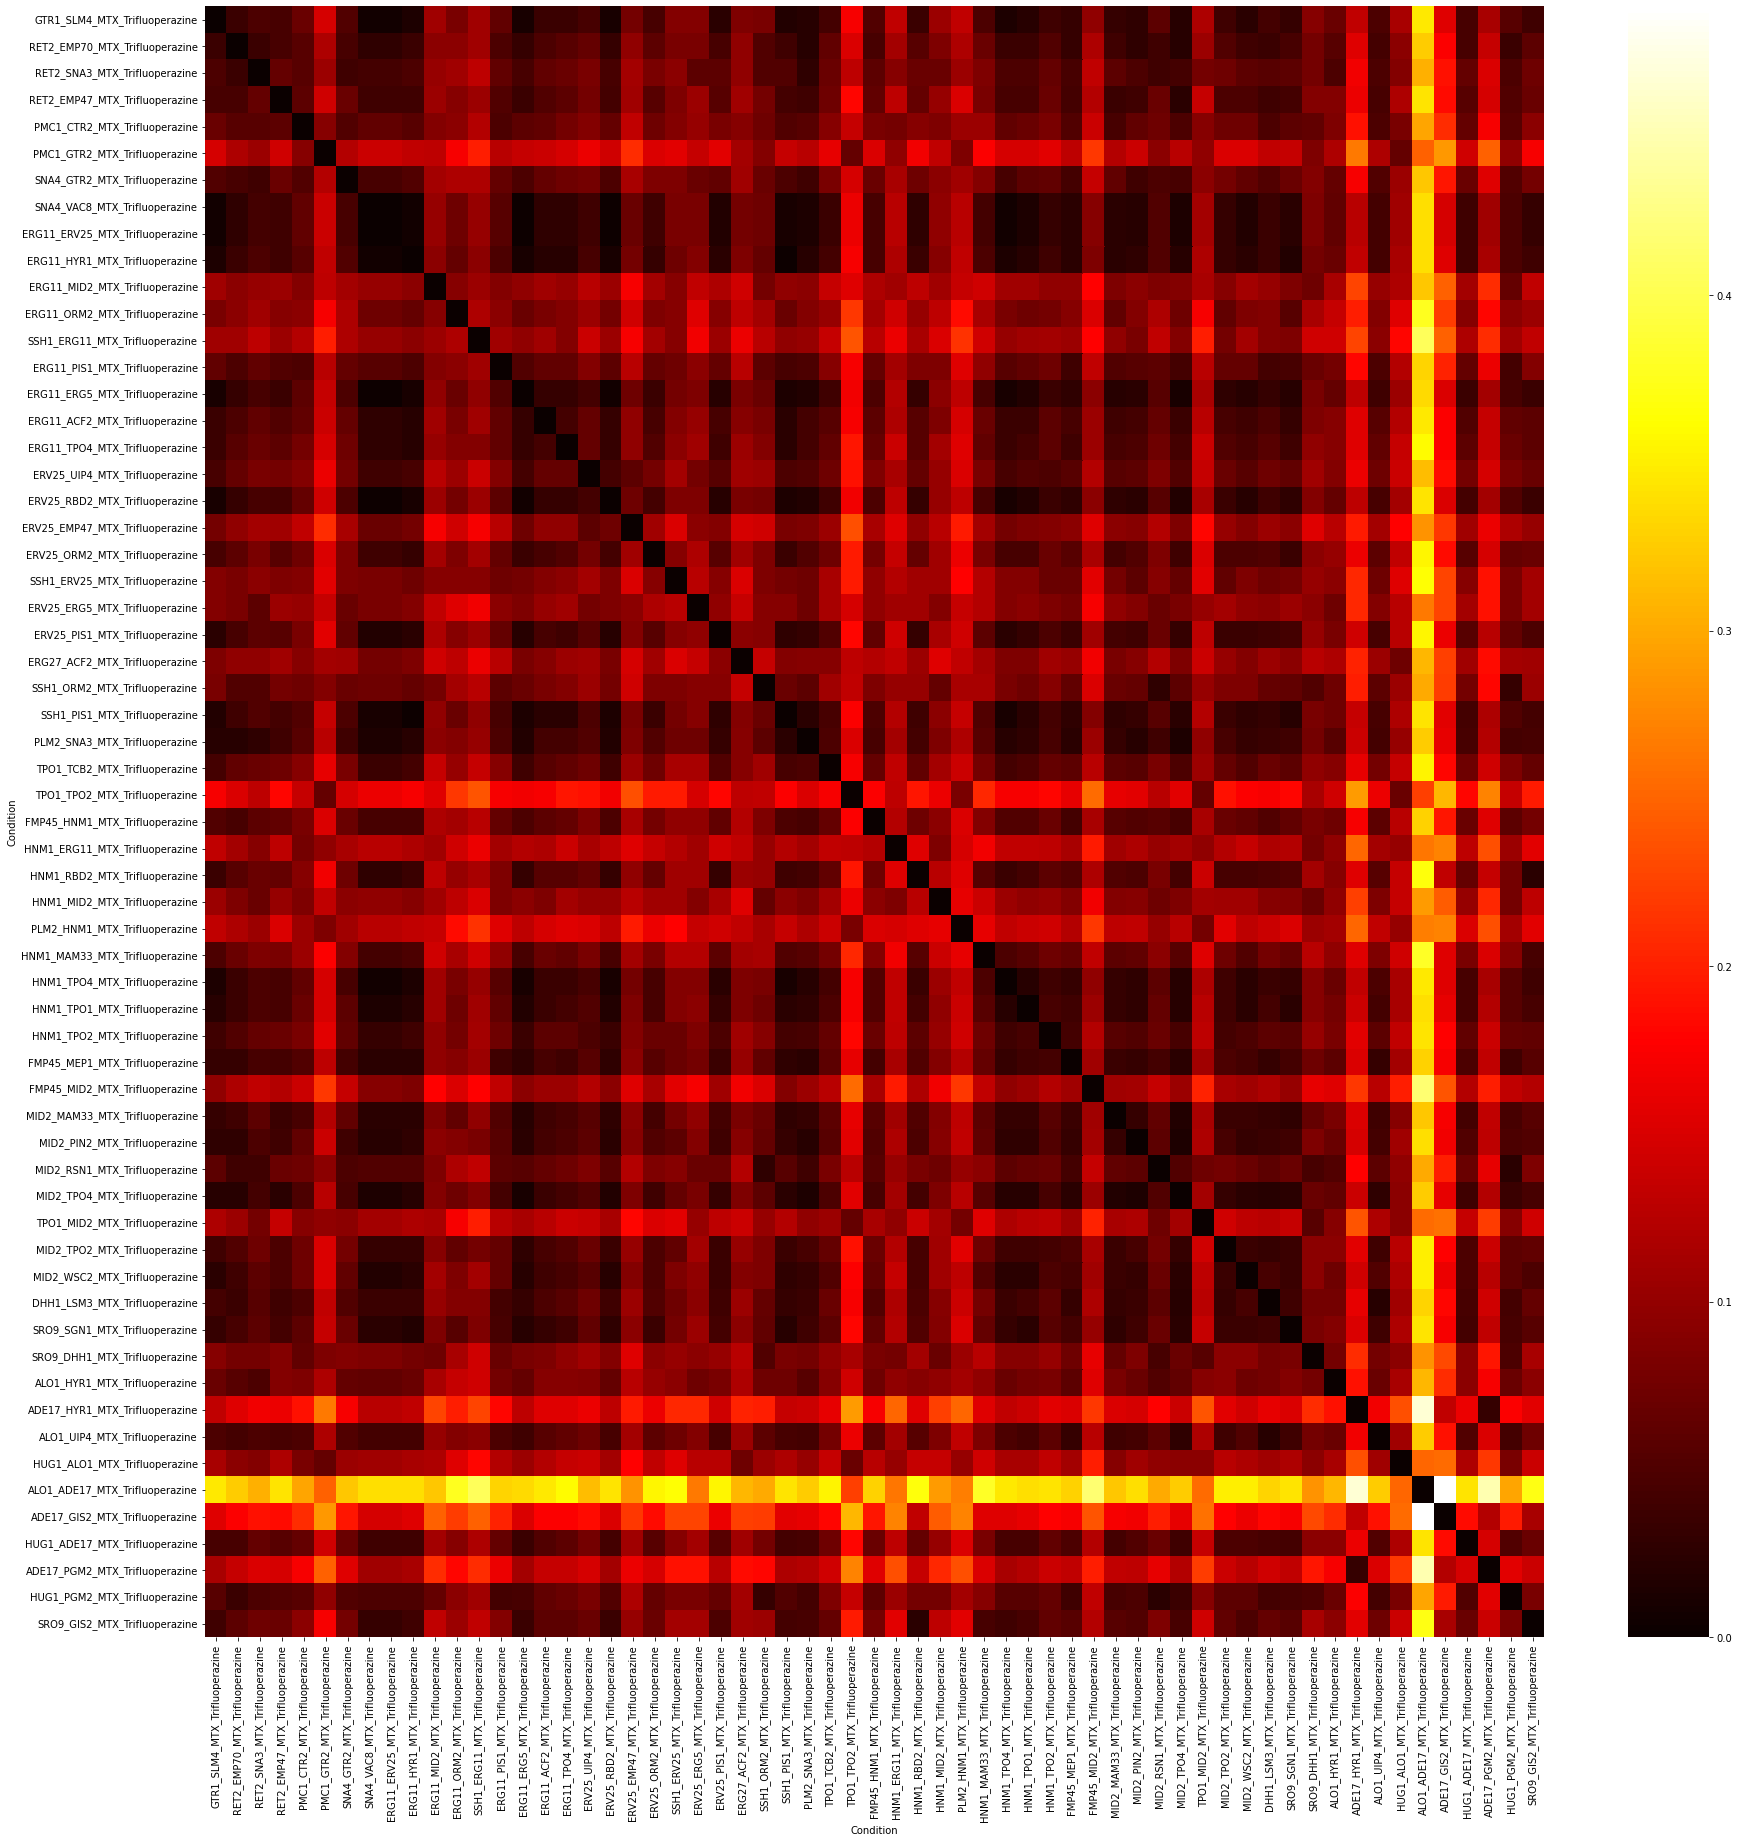

In [ ]:
DRUG_HEATMAPs = []
for DRUG in ['5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine']:
    NES_piQTLs = pd.read_csv(f'{root_path}/results/05_piQTL_tables/ES_vs_NES/{DRUG}_NES_piQTLs.csv').sort_values('SNP')
    NES_piQTLs['SNP_ID'] = [ f'CHR{NES_piQTLs["Chr"][idx]}_{NES_piQTLs["SNP"][idx]}'.replace('CHRMT_', 'CHR17_') for idx in NES_piQTLs.index ]
    NES_piQTLs_IDs = NES_piQTLs[~NES_piQTLs['SNP_ID'].str.contains('CHR0')]['SNP_ID'].unique()
    NES_piQTLs_IDs = list(NES_piQTLs_IDs)
    NES_piQTLs_IDs.insert(0,'Condition')
    DRUG_HEATMAP = piQTL_QTLs[piQTL_QTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)

    PPI_order = []
    for PPI in piQTLs.index[g.dendrogram_row.reordered_ind]:
        if PPI in ppi['ppi'].values :
            PPI_order.append(f"{PPI.replace(':','_')}_MTX_{DRUG}")
        else :
            PPI_order.append(f"{PPI.split(':')[1]}:{PPI.split(':')[0]}_MTX_{DRUG}".replace(':','_'))

    # print(PPI_order)

    DRUG_HEATMAP = piQTL_QTLs[piQTL_QTLs['Condition'].isin(PPI_order)]
    DRUG_HEATMAP['Condition'] = DRUG_HEATMAP['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order))
    DRUG_HEATMAP = DRUG_HEATMAP.sort_values("Condition").reset_index(drop=True)
    DRUG_HEATMAP = DRUG_HEATMAP[NES_piQTLs_IDs]

    display(DRUG_HEATMAP.shape)

    DRUG_hamming = pd.DataFrame(
        squareform(pdist(DRUG_HEATMAP.set_index('Condition'), metric='hamming')),
        columns = DRUG_HEATMAP.set_index('Condition').index,
        index = DRUG_HEATMAP.set_index('Condition').index
    )

    # display(DRUG_hamming)

    f = plt.figure(figsize=(30,30))
    sns.heatmap(DRUG_hamming, cmap='hot', xticklabels=True, yticklabels=True)
    f.savefig(f"{root_path}/figures/supp_figures/distance_heatmap_PPI_distance_manhattan_{DRUG}_NES.png", dpi=300)
